In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : ['normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_normalized_e_n_e_0_0_e_0_0_basal_seg_data_norm_e_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1078212, 92)
(1078212, 3)
validation
(151755, 92)
(151755, 3)
test
(135990, 92)
(135990, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 784643 (2.99 MB)


Trainable params: 784643 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:36 - loss: 1.3069 - STD: 0.2214 - MAE: 0.4438

  6/108 [>.............................] - ETA: 1s - loss: 1.1703 - STD: 0.1114 - MAE: 0.4438  

 11/108 [==>...........................] - ETA: 1s - loss: 1.1429 - STD: 0.0824 - MAE: 0.4440

 16/108 [===>..........................] - ETA: 0s - loss: 1.1328 - STD: 0.0724 - MAE: 0.4441

 21/108 [====>.........................] - ETA: 0s - loss: 1.1256 - STD: 0.0641 - MAE: 0.4440

 26/108 [======>.......................] - ETA: 0s - loss: 1.1200 - STD: 0.0562 - MAE: 0.4438

 31/108 [=======>......................] - ETA: 0s - loss: 1.1156 - STD: 0.0517 - MAE: 0.4436

 36/108 [=========>....................] - ETA: 0s - loss: 1.1107 - STD: 0.0471 - MAE: 0.4431

 41/108 [==========>...................] - ETA: 0s - loss: 1.1044 - STD: 0.0456 - MAE: 0.4420

 46/108 [===========>..................] - ETA: 0s - loss: 1.0951 - STD: 0.0476 - MAE: 0.4398

 51/108 [=============>................] - ETA: 0s - loss: 1.0832 - STD: 0.0548 - MAE: 0.4361

 56/108 [==============>...............] - ETA: 0s - loss: 1.0715 - STD: 0.0650 - MAE: 0.4313

 61/108 [===============>..............] - ETA: 0s - loss: 1.0604 - STD: 0.0740 - MAE: 0.4269

 66/108 [=================>............] - ETA: 0s - loss: 1.0502 - STD: 0.0811 - MAE: 0.4232

 71/108 [==================>...........] - ETA: 0s - loss: 1.0402 - STD: 0.0876 - MAE: 0.4196

 75/108 [===================>..........] - ETA: 0s - loss: 1.0329 - STD: 0.0926 - MAE: 0.4168

 80/108 [=====================>........] - ETA: 0s - loss: 1.0239 - STD: 0.0990 - MAE: 0.4133

 85/108 [======================>.......] - ETA: 0s - loss: 1.0155 - STD: 0.1045 - MAE: 0.4101

 90/108 [========================>.....] - ETA: 0s - loss: 1.0080 - STD: 0.1096 - MAE: 0.4072

 95/108 [=========================>....] - ETA: 0s - loss: 1.0005 - STD: 0.1146 - MAE: 0.4042

100/108 [==========================>...] - ETA: 0s - loss: 0.9935 - STD: 0.1195 - MAE: 0.4013

105/108 [============================>.] - ETA: 0s - loss: 0.9870 - STD: 0.1240 - MAE: 0.3987

108/108 [==============================] - 4s 26ms/step - loss: 0.9833 - STD: 0.1266 - MAE: 0.3971 - val_loss: 0.8140 - val_STD: 0.2213 - val_MAE: 0.3323


Epoch 2/10000


  1/108 [..............................] - ETA: 2s - loss: 0.8519 - STD: 0.2215 - MAE: 0.3413

  6/108 [>.............................] - ETA: 1s - loss: 0.8518 - STD: 0.2199 - MAE: 0.3420

 11/108 [==>...........................] - ETA: 1s - loss: 0.8507 - STD: 0.2220 - MAE: 0.3409

 16/108 [===>..........................] - ETA: 0s - loss: 0.8493 - STD: 0.2233 - MAE: 0.3401

 21/108 [====>.........................] - ETA: 0s - loss: 0.8482 - STD: 0.2239 - MAE: 0.3397

 26/108 [======>.......................] - ETA: 0s - loss: 0.8464 - STD: 0.2253 - MAE: 0.3387

 31/108 [=======>......................] - ETA: 0s - loss: 0.8455 - STD: 0.2265 - MAE: 0.3380

 36/108 [=========>....................] - ETA: 0s - loss: 0.8444 - STD: 0.2272 - MAE: 0.3375

 41/108 [==========>...................] - ETA: 0s - loss: 0.8432 - STD: 0.2283 - MAE: 0.3367

 46/108 [===========>..................] - ETA: 0s - loss: 0.8416 - STD: 0.2290 - MAE: 0.3360

 51/108 [=============>................] - ETA: 0s - loss: 0.8406 - STD: 0.2298 - MAE: 0.3355

 56/108 [==============>...............] - ETA: 0s - loss: 0.8390 - STD: 0.2305 - MAE: 0.3348

 61/108 [===============>..............] - ETA: 0s - loss: 0.8379 - STD: 0.2313 - MAE: 0.3342

 66/108 [=================>............] - ETA: 0s - loss: 0.8363 - STD: 0.2319 - MAE: 0.3336

 71/108 [==================>...........] - ETA: 0s - loss: 0.8352 - STD: 0.2328 - MAE: 0.3329

 76/108 [====================>.........] - ETA: 0s - loss: 0.8340 - STD: 0.2334 - MAE: 0.3323

 81/108 [=====================>........] - ETA: 0s - loss: 0.8326 - STD: 0.2342 - MAE: 0.3316

 86/108 [======================>.......] - ETA: 0s - loss: 0.8315 - STD: 0.2350 - MAE: 0.3310

 91/108 [========================>.....] - ETA: 0s - loss: 0.8300 - STD: 0.2358 - MAE: 0.3303

 96/108 [=========================>....] - ETA: 0s - loss: 0.8288 - STD: 0.2365 - MAE: 0.3297

101/108 [===========================>..] - ETA: 0s - loss: 0.8276 - STD: 0.2371 - MAE: 0.3291

106/108 [============================>.] - ETA: 0s - loss: 0.8263 - STD: 0.2379 - MAE: 0.3285

108/108 [==============================] - 1s 12ms/step - loss: 0.8258 - STD: 0.2382 - MAE: 0.3282 - val_loss: 0.7855 - val_STD: 0.2556 - val_MAE: 0.3094


Epoch 3/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7987 - STD: 0.2459 - MAE: 0.3187

  6/108 [>.............................] - ETA: 1s - loss: 0.7995 - STD: 0.2520 - MAE: 0.3160

 11/108 [==>...........................] - ETA: 1s - loss: 0.7986 - STD: 0.2530 - MAE: 0.3153

 16/108 [===>..........................] - ETA: 0s - loss: 0.7981 - STD: 0.2522 - MAE: 0.3156

 21/108 [====>.........................] - ETA: 0s - loss: 0.7976 - STD: 0.2525 - MAE: 0.3154

 26/108 [======>.......................] - ETA: 0s - loss: 0.7964 - STD: 0.2533 - MAE: 0.3148

 31/108 [=======>......................] - ETA: 0s - loss: 0.7950 - STD: 0.2537 - MAE: 0.3143

 36/108 [=========>....................] - ETA: 0s - loss: 0.7939 - STD: 0.2541 - MAE: 0.3139

 41/108 [==========>...................] - ETA: 0s - loss: 0.7925 - STD: 0.2545 - MAE: 0.3134

 46/108 [===========>..................] - ETA: 0s - loss: 0.7913 - STD: 0.2551 - MAE: 0.3129

 51/108 [=============>................] - ETA: 0s - loss: 0.7913 - STD: 0.2557 - MAE: 0.3126

 56/108 [==============>...............] - ETA: 0s - loss: 0.7903 - STD: 0.2558 - MAE: 0.3123

 61/108 [===============>..............] - ETA: 0s - loss: 0.7887 - STD: 0.2563 - MAE: 0.3118

 66/108 [=================>............] - ETA: 0s - loss: 0.7880 - STD: 0.2568 - MAE: 0.3114

 71/108 [==================>...........] - ETA: 0s - loss: 0.7872 - STD: 0.2573 - MAE: 0.3110

 76/108 [====================>.........] - ETA: 0s - loss: 0.7864 - STD: 0.2574 - MAE: 0.3107

 81/108 [=====================>........] - ETA: 0s - loss: 0.7860 - STD: 0.2577 - MAE: 0.3105

 86/108 [======================>.......] - ETA: 0s - loss: 0.7853 - STD: 0.2580 - MAE: 0.3102

 91/108 [========================>.....] - ETA: 0s - loss: 0.7845 - STD: 0.2584 - MAE: 0.3099

 96/108 [=========================>....] - ETA: 0s - loss: 0.7843 - STD: 0.2590 - MAE: 0.3095

101/108 [===========================>..] - ETA: 0s - loss: 0.7842 - STD: 0.2592 - MAE: 0.3094

106/108 [============================>.] - ETA: 0s - loss: 0.7836 - STD: 0.2594 - MAE: 0.3092

108/108 [==============================] - 1s 12ms/step - loss: 0.7834 - STD: 0.2596 - MAE: 0.3090 - val_loss: 0.7691 - val_STD: 0.2663 - val_MAE: 0.3030


Epoch 4/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7713 - STD: 0.2644 - MAE: 0.3040

  6/108 [>.............................] - ETA: 1s - loss: 0.7672 - STD: 0.2612 - MAE: 0.3048

 11/108 [==>...........................] - ETA: 1s - loss: 0.7652 - STD: 0.2652 - MAE: 0.3024

 16/108 [===>..........................] - ETA: 0s - loss: 0.7647 - STD: 0.2653 - MAE: 0.3023

 21/108 [====>.........................] - ETA: 0s - loss: 0.7648 - STD: 0.2654 - MAE: 0.3023

 26/108 [======>.......................] - ETA: 0s - loss: 0.7644 - STD: 0.2657 - MAE: 0.3022

 31/108 [=======>......................] - ETA: 0s - loss: 0.7651 - STD: 0.2655 - MAE: 0.3024

 36/108 [=========>....................] - ETA: 0s - loss: 0.7644 - STD: 0.2661 - MAE: 0.3019

 41/108 [==========>...................] - ETA: 0s - loss: 0.7641 - STD: 0.2666 - MAE: 0.3016

 46/108 [===========>..................] - ETA: 0s - loss: 0.7640 - STD: 0.2666 - MAE: 0.3016

 51/108 [=============>................] - ETA: 0s - loss: 0.7632 - STD: 0.2667 - MAE: 0.3014

 56/108 [==============>...............] - ETA: 0s - loss: 0.7632 - STD: 0.2669 - MAE: 0.3013

 61/108 [===============>..............] - ETA: 0s - loss: 0.7629 - STD: 0.2671 - MAE: 0.3011

 66/108 [=================>............] - ETA: 0s - loss: 0.7625 - STD: 0.2673 - MAE: 0.3009

 71/108 [==================>...........] - ETA: 0s - loss: 0.7619 - STD: 0.2674 - MAE: 0.3008

 76/108 [====================>.........] - ETA: 0s - loss: 0.7617 - STD: 0.2676 - MAE: 0.3006

 81/108 [=====================>........] - ETA: 0s - loss: 0.7613 - STD: 0.2676 - MAE: 0.3006

 86/108 [======================>.......] - ETA: 0s - loss: 0.7611 - STD: 0.2677 - MAE: 0.3004

 91/108 [========================>.....] - ETA: 0s - loss: 0.7607 - STD: 0.2678 - MAE: 0.3003

 96/108 [=========================>....] - ETA: 0s - loss: 0.7601 - STD: 0.2679 - MAE: 0.3002

101/108 [===========================>..] - ETA: 0s - loss: 0.7596 - STD: 0.2680 - MAE: 0.3000

106/108 [============================>.] - ETA: 0s - loss: 0.7590 - STD: 0.2683 - MAE: 0.2997

108/108 [==============================] - 1s 12ms/step - loss: 0.7587 - STD: 0.2684 - MAE: 0.2996 - val_loss: 0.7473 - val_STD: 0.2769 - val_MAE: 0.2915


Epoch 5/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7442 - STD: 0.2686 - MAE: 0.2968

  6/108 [>.............................] - ETA: 1s - loss: 0.7513 - STD: 0.2720 - MAE: 0.2963

 11/108 [==>...........................] - ETA: 1s - loss: 0.7500 - STD: 0.2720 - MAE: 0.2960

 16/108 [===>..........................] - ETA: 0s - loss: 0.7502 - STD: 0.2724 - MAE: 0.2958

 21/108 [====>.........................] - ETA: 0s - loss: 0.7512 - STD: 0.2721 - MAE: 0.2961

 26/108 [======>.......................] - ETA: 0s - loss: 0.7520 - STD: 0.2723 - MAE: 0.2961

 31/108 [=======>......................] - ETA: 0s - loss: 0.7520 - STD: 0.2727 - MAE: 0.2960

 36/108 [=========>....................] - ETA: 0s - loss: 0.7513 - STD: 0.2730 - MAE: 0.2956

 41/108 [==========>...................] - ETA: 0s - loss: 0.7500 - STD: 0.2731 - MAE: 0.2953

 46/108 [===========>..................] - ETA: 0s - loss: 0.7489 - STD: 0.2735 - MAE: 0.2948

 51/108 [=============>................] - ETA: 0s - loss: 0.7482 - STD: 0.2735 - MAE: 0.2947

 56/108 [==============>...............] - ETA: 0s - loss: 0.7475 - STD: 0.2737 - MAE: 0.2944

 61/108 [===============>..............] - ETA: 0s - loss: 0.7475 - STD: 0.2737 - MAE: 0.2944

 66/108 [=================>............] - ETA: 0s - loss: 0.7467 - STD: 0.2739 - MAE: 0.2941

 71/108 [==================>...........] - ETA: 0s - loss: 0.7463 - STD: 0.2740 - MAE: 0.2940

 76/108 [====================>.........] - ETA: 0s - loss: 0.7457 - STD: 0.2742 - MAE: 0.2938

 81/108 [=====================>........] - ETA: 0s - loss: 0.7453 - STD: 0.2742 - MAE: 0.2937

 86/108 [======================>.......] - ETA: 0s - loss: 0.7447 - STD: 0.2743 - MAE: 0.2935

 91/108 [========================>.....] - ETA: 0s - loss: 0.7448 - STD: 0.2745 - MAE: 0.2934

 96/108 [=========================>....] - ETA: 0s - loss: 0.7443 - STD: 0.2747 - MAE: 0.2932

101/108 [===========================>..] - ETA: 0s - loss: 0.7441 - STD: 0.2748 - MAE: 0.2931

106/108 [============================>.] - ETA: 0s - loss: 0.7439 - STD: 0.2749 - MAE: 0.2930

108/108 [==============================] - 1s 12ms/step - loss: 0.7438 - STD: 0.2750 - MAE: 0.2929 - val_loss: 0.7321 - val_STD: 0.2856 - val_MAE: 0.2837


Epoch 6/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7311 - STD: 0.2809 - MAE: 0.2871

  6/108 [>.............................] - ETA: 1s - loss: 0.7361 - STD: 0.2753 - MAE: 0.2914

 11/108 [==>...........................] - ETA: 1s - loss: 0.7363 - STD: 0.2777 - MAE: 0.2899

 16/108 [===>..........................] - ETA: 0s - loss: 0.7361 - STD: 0.2770 - MAE: 0.2901

 21/108 [====>.........................] - ETA: 0s - loss: 0.7364 - STD: 0.2774 - MAE: 0.2900

 26/108 [======>.......................] - ETA: 0s - loss: 0.7366 - STD: 0.2774 - MAE: 0.2901

 31/108 [=======>......................] - ETA: 0s - loss: 0.7370 - STD: 0.2777 - MAE: 0.2899

 36/108 [=========>....................] - ETA: 0s - loss: 0.7366 - STD: 0.2775 - MAE: 0.2900

 41/108 [==========>...................] - ETA: 0s - loss: 0.7367 - STD: 0.2778 - MAE: 0.2899

 46/108 [===========>..................] - ETA: 0s - loss: 0.7367 - STD: 0.2777 - MAE: 0.2899

 51/108 [=============>................] - ETA: 0s - loss: 0.7362 - STD: 0.2776 - MAE: 0.2899

 56/108 [==============>...............] - ETA: 0s - loss: 0.7354 - STD: 0.2778 - MAE: 0.2896

 61/108 [===============>..............] - ETA: 0s - loss: 0.7349 - STD: 0.2781 - MAE: 0.2893

 66/108 [=================>............] - ETA: 0s - loss: 0.7345 - STD: 0.2783 - MAE: 0.2891

 71/108 [==================>...........] - ETA: 0s - loss: 0.7342 - STD: 0.2784 - MAE: 0.2890

 76/108 [====================>.........] - ETA: 0s - loss: 0.7341 - STD: 0.2784 - MAE: 0.2890

 81/108 [=====================>........] - ETA: 0s - loss: 0.7336 - STD: 0.2786 - MAE: 0.2887

 86/108 [======================>.......] - ETA: 0s - loss: 0.7333 - STD: 0.2787 - MAE: 0.2886

 91/108 [========================>.....] - ETA: 0s - loss: 0.7331 - STD: 0.2789 - MAE: 0.2885

 96/108 [=========================>....] - ETA: 0s - loss: 0.7330 - STD: 0.2790 - MAE: 0.2884

101/108 [===========================>..] - ETA: 0s - loss: 0.7329 - STD: 0.2791 - MAE: 0.2883

106/108 [============================>.] - ETA: 0s - loss: 0.7328 - STD: 0.2791 - MAE: 0.2883

108/108 [==============================] - 1s 12ms/step - loss: 0.7327 - STD: 0.2791 - MAE: 0.2883 - val_loss: 0.7290 - val_STD: 0.2883 - val_MAE: 0.2808


Epoch 7/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7301 - STD: 0.2772 - MAE: 0.2889

  6/108 [>.............................] - ETA: 1s - loss: 0.7226 - STD: 0.2818 - MAE: 0.2846

 11/108 [==>...........................] - ETA: 1s - loss: 0.7233 - STD: 0.2819 - MAE: 0.2846

 16/108 [===>..........................] - ETA: 0s - loss: 0.7239 - STD: 0.2827 - MAE: 0.2843

 21/108 [====>.........................] - ETA: 0s - loss: 0.7250 - STD: 0.2827 - MAE: 0.2845

 26/108 [======>.......................] - ETA: 0s - loss: 0.7279 - STD: 0.2828 - MAE: 0.2851

 31/108 [=======>......................] - ETA: 0s - loss: 0.7297 - STD: 0.2827 - MAE: 0.2855

 36/108 [=========>....................] - ETA: 0s - loss: 0.7308 - STD: 0.2824 - MAE: 0.2859

 41/108 [==========>...................] - ETA: 0s - loss: 0.7307 - STD: 0.2820 - MAE: 0.2861

 46/108 [===========>..................] - ETA: 0s - loss: 0.7308 - STD: 0.2819 - MAE: 0.2862

 51/108 [=============>................] - ETA: 0s - loss: 0.7305 - STD: 0.2819 - MAE: 0.2862

 56/108 [==============>...............] - ETA: 0s - loss: 0.7302 - STD: 0.2819 - MAE: 0.2861

 61/108 [===============>..............] - ETA: 0s - loss: 0.7300 - STD: 0.2816 - MAE: 0.2862

 66/108 [=================>............] - ETA: 0s - loss: 0.7297 - STD: 0.2815 - MAE: 0.2862

 71/108 [==================>...........] - ETA: 0s - loss: 0.7292 - STD: 0.2816 - MAE: 0.2861

 76/108 [====================>.........] - ETA: 0s - loss: 0.7291 - STD: 0.2816 - MAE: 0.2860

 81/108 [=====================>........] - ETA: 0s - loss: 0.7293 - STD: 0.2817 - MAE: 0.2861

 86/108 [======================>.......] - ETA: 0s - loss: 0.7291 - STD: 0.2816 - MAE: 0.2861

 91/108 [========================>.....] - ETA: 0s - loss: 0.7290 - STD: 0.2817 - MAE: 0.2860

 96/108 [=========================>....] - ETA: 0s - loss: 0.7287 - STD: 0.2817 - MAE: 0.2860

101/108 [===========================>..] - ETA: 0s - loss: 0.7285 - STD: 0.2818 - MAE: 0.2858

106/108 [============================>.] - ETA: 0s - loss: 0.7282 - STD: 0.2818 - MAE: 0.2857

108/108 [==============================] - 1s 12ms/step - loss: 0.7282 - STD: 0.2819 - MAE: 0.2857 - val_loss: 0.7192 - val_STD: 0.2943 - val_MAE: 0.2755


Epoch 8/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7267 - STD: 0.2849 - MAE: 0.2835

  6/108 [>.............................] - ETA: 1s - loss: 0.7211 - STD: 0.2841 - MAE: 0.2829

 11/108 [==>...........................] - ETA: 1s - loss: 0.7205 - STD: 0.2831 - MAE: 0.2835

 16/108 [===>..........................] - ETA: 0s - loss: 0.7208 - STD: 0.2828 - MAE: 0.2837

 21/108 [====>.........................] - ETA: 0s - loss: 0.7210 - STD: 0.2831 - MAE: 0.2836

 26/108 [======>.......................] - ETA: 0s - loss: 0.7209 - STD: 0.2834 - MAE: 0.2833

 31/108 [=======>......................] - ETA: 0s - loss: 0.7208 - STD: 0.2836 - MAE: 0.2832

 36/108 [=========>....................] - ETA: 0s - loss: 0.7207 - STD: 0.2836 - MAE: 0.2832

 41/108 [==========>...................] - ETA: 0s - loss: 0.7209 - STD: 0.2835 - MAE: 0.2832

 46/108 [===========>..................] - ETA: 0s - loss: 0.7212 - STD: 0.2836 - MAE: 0.2833

 51/108 [=============>................] - ETA: 0s - loss: 0.7214 - STD: 0.2835 - MAE: 0.2834

 56/108 [==============>...............] - ETA: 0s - loss: 0.7215 - STD: 0.2835 - MAE: 0.2834

 61/108 [===============>..............] - ETA: 0s - loss: 0.7210 - STD: 0.2837 - MAE: 0.2832

 66/108 [=================>............] - ETA: 0s - loss: 0.7208 - STD: 0.2837 - MAE: 0.2832

 71/108 [==================>...........] - ETA: 0s - loss: 0.7201 - STD: 0.2839 - MAE: 0.2829

 76/108 [====================>.........] - ETA: 0s - loss: 0.7200 - STD: 0.2841 - MAE: 0.2828

 81/108 [=====================>........] - ETA: 0s - loss: 0.7196 - STD: 0.2842 - MAE: 0.2826

 86/108 [======================>.......] - ETA: 0s - loss: 0.7197 - STD: 0.2842 - MAE: 0.2826

 91/108 [========================>.....] - ETA: 0s - loss: 0.7197 - STD: 0.2843 - MAE: 0.2826

 96/108 [=========================>....] - ETA: 0s - loss: 0.7198 - STD: 0.2843 - MAE: 0.2826

101/108 [===========================>..] - ETA: 0s - loss: 0.7196 - STD: 0.2843 - MAE: 0.2825

106/108 [============================>.] - ETA: 0s - loss: 0.7196 - STD: 0.2843 - MAE: 0.2826

108/108 [==============================] - 1s 12ms/step - loss: 0.7196 - STD: 0.2843 - MAE: 0.2826 - val_loss: 0.7158 - val_STD: 0.2951 - val_MAE: 0.2744


Epoch 9/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7172 - STD: 0.2885 - MAE: 0.2795

  6/108 [>.............................] - ETA: 1s - loss: 0.7181 - STD: 0.2851 - MAE: 0.2819

 11/108 [==>...........................] - ETA: 1s - loss: 0.7184 - STD: 0.2850 - MAE: 0.2819

 16/108 [===>..........................] - ETA: 0s - loss: 0.7196 - STD: 0.2856 - MAE: 0.2819

 21/108 [====>.........................] - ETA: 0s - loss: 0.7180 - STD: 0.2852 - MAE: 0.2817

 26/108 [======>.......................] - ETA: 0s - loss: 0.7174 - STD: 0.2858 - MAE: 0.2812

 31/108 [=======>......................] - ETA: 0s - loss: 0.7174 - STD: 0.2859 - MAE: 0.2812

 36/108 [=========>....................] - ETA: 0s - loss: 0.7179 - STD: 0.2858 - MAE: 0.2814

 41/108 [==========>...................] - ETA: 0s - loss: 0.7179 - STD: 0.2855 - MAE: 0.2816

 46/108 [===========>..................] - ETA: 0s - loss: 0.7185 - STD: 0.2854 - MAE: 0.2817

 51/108 [=============>................] - ETA: 0s - loss: 0.7198 - STD: 0.2856 - MAE: 0.2819

 56/108 [==============>...............] - ETA: 0s - loss: 0.7198 - STD: 0.2854 - MAE: 0.2820

 61/108 [===============>..............] - ETA: 0s - loss: 0.7201 - STD: 0.2853 - MAE: 0.2821

 66/108 [=================>............] - ETA: 0s - loss: 0.7203 - STD: 0.2852 - MAE: 0.2822

 71/108 [==================>...........] - ETA: 0s - loss: 0.7203 - STD: 0.2852 - MAE: 0.2822

 76/108 [====================>.........] - ETA: 0s - loss: 0.7199 - STD: 0.2851 - MAE: 0.2822

 81/108 [=====================>........] - ETA: 0s - loss: 0.7194 - STD: 0.2852 - MAE: 0.2821

 86/108 [======================>.......] - ETA: 0s - loss: 0.7190 - STD: 0.2853 - MAE: 0.2819

 91/108 [========================>.....] - ETA: 0s - loss: 0.7189 - STD: 0.2853 - MAE: 0.2818

 96/108 [=========================>....] - ETA: 0s - loss: 0.7187 - STD: 0.2854 - MAE: 0.2818

101/108 [===========================>..] - ETA: 0s - loss: 0.7189 - STD: 0.2853 - MAE: 0.2819

106/108 [============================>.] - ETA: 0s - loss: 0.7187 - STD: 0.2853 - MAE: 0.2818

108/108 [==============================] - 1s 11ms/step - loss: 0.7188 - STD: 0.2854 - MAE: 0.2818 - val_loss: 0.7262 - val_STD: 0.2932 - val_MAE: 0.2782


Epoch 10/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7205 - STD: 0.2869 - MAE: 0.2811

  6/108 [>.............................] - ETA: 1s - loss: 0.7231 - STD: 0.2868 - MAE: 0.2820

 11/108 [==>...........................] - ETA: 1s - loss: 0.7224 - STD: 0.2842 - MAE: 0.2834

 16/108 [===>..........................] - ETA: 0s - loss: 0.7208 - STD: 0.2845 - MAE: 0.2829

 21/108 [====>.........................] - ETA: 0s - loss: 0.7181 - STD: 0.2845 - MAE: 0.2823

 26/108 [======>.......................] - ETA: 0s - loss: 0.7180 - STD: 0.2851 - MAE: 0.2819

 31/108 [=======>......................] - ETA: 0s - loss: 0.7185 - STD: 0.2851 - MAE: 0.2819

 36/108 [=========>....................] - ETA: 0s - loss: 0.7182 - STD: 0.2852 - MAE: 0.2818

 41/108 [==========>...................] - ETA: 0s - loss: 0.7179 - STD: 0.2853 - MAE: 0.2817

 46/108 [===========>..................] - ETA: 0s - loss: 0.7167 - STD: 0.2854 - MAE: 0.2814

 51/108 [=============>................] - ETA: 0s - loss: 0.7165 - STD: 0.2856 - MAE: 0.2813

 56/108 [==============>...............] - ETA: 0s - loss: 0.7161 - STD: 0.2856 - MAE: 0.2812

 61/108 [===============>..............] - ETA: 0s - loss: 0.7164 - STD: 0.2860 - MAE: 0.2810

 66/108 [=================>............] - ETA: 0s - loss: 0.7171 - STD: 0.2861 - MAE: 0.2811

 71/108 [==================>...........] - ETA: 0s - loss: 0.7175 - STD: 0.2860 - MAE: 0.2813

 76/108 [====================>.........] - ETA: 0s - loss: 0.7175 - STD: 0.2859 - MAE: 0.2813

 81/108 [=====================>........] - ETA: 0s - loss: 0.7174 - STD: 0.2859 - MAE: 0.2813

 86/108 [======================>.......] - ETA: 0s - loss: 0.7173 - STD: 0.2858 - MAE: 0.2813

 91/108 [========================>.....] - ETA: 0s - loss: 0.7173 - STD: 0.2858 - MAE: 0.2813

 96/108 [=========================>....] - ETA: 0s - loss: 0.7169 - STD: 0.2859 - MAE: 0.2812

101/108 [===========================>..] - ETA: 0s - loss: 0.7168 - STD: 0.2859 - MAE: 0.2811

106/108 [============================>.] - ETA: 0s - loss: 0.7166 - STD: 0.2859 - MAE: 0.2811

108/108 [==============================] - 1s 12ms/step - loss: 0.7164 - STD: 0.2860 - MAE: 0.2810 - val_loss: 0.7168 - val_STD: 0.2927 - val_MAE: 0.2762


Epoch 11/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7102 - STD: 0.2846 - MAE: 0.2807

  6/108 [>.............................] - ETA: 1s - loss: 0.7134 - STD: 0.2876 - MAE: 0.2793

 11/108 [==>...........................] - ETA: 1s - loss: 0.7140 - STD: 0.2868 - MAE: 0.2799

 16/108 [===>..........................] - ETA: 0s - loss: 0.7130 - STD: 0.2870 - MAE: 0.2797

 21/108 [====>.........................] - ETA: 0s - loss: 0.7134 - STD: 0.2868 - MAE: 0.2799

 26/108 [======>.......................] - ETA: 0s - loss: 0.7126 - STD: 0.2871 - MAE: 0.2796

 31/108 [=======>......................] - ETA: 0s - loss: 0.7126 - STD: 0.2872 - MAE: 0.2795

 36/108 [=========>....................] - ETA: 0s - loss: 0.7127 - STD: 0.2869 - MAE: 0.2797

 41/108 [==========>...................] - ETA: 0s - loss: 0.7132 - STD: 0.2871 - MAE: 0.2797

 46/108 [===========>..................] - ETA: 0s - loss: 0.7136 - STD: 0.2872 - MAE: 0.2798

 51/108 [=============>................] - ETA: 0s - loss: 0.7140 - STD: 0.2870 - MAE: 0.2800

 57/108 [==============>...............] - ETA: 0s - loss: 0.7143 - STD: 0.2870 - MAE: 0.2800

 62/108 [================>.............] - ETA: 0s - loss: 0.7145 - STD: 0.2870 - MAE: 0.2801

 67/108 [=================>............] - ETA: 0s - loss: 0.7148 - STD: 0.2868 - MAE: 0.2802

 72/108 [===================>..........] - ETA: 0s - loss: 0.7149 - STD: 0.2869 - MAE: 0.2802

 77/108 [====================>.........] - ETA: 0s - loss: 0.7145 - STD: 0.2867 - MAE: 0.2802

 82/108 [=====================>........] - ETA: 0s - loss: 0.7145 - STD: 0.2868 - MAE: 0.2802

 87/108 [=======================>......] - ETA: 0s - loss: 0.7143 - STD: 0.2870 - MAE: 0.2800

 92/108 [========================>.....] - ETA: 0s - loss: 0.7144 - STD: 0.2869 - MAE: 0.2801

 97/108 [=========================>....] - ETA: 0s - loss: 0.7142 - STD: 0.2870 - MAE: 0.2800

102/108 [===========================>..] - ETA: 0s - loss: 0.7140 - STD: 0.2870 - MAE: 0.2800

107/108 [============================>.] - ETA: 0s - loss: 0.7137 - STD: 0.2870 - MAE: 0.2799

108/108 [==============================] - 1s 12ms/step - loss: 0.7136 - STD: 0.2871 - MAE: 0.2798 - val_loss: 0.7086 - val_STD: 0.2969 - val_MAE: 0.2717


Epoch 12/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7005 - STD: 0.2898 - MAE: 0.2758

  6/108 [>.............................] - ETA: 1s - loss: 0.7049 - STD: 0.2890 - MAE: 0.2770

 11/108 [==>...........................] - ETA: 1s - loss: 0.7077 - STD: 0.2889 - MAE: 0.2776

 16/108 [===>..........................] - ETA: 0s - loss: 0.7078 - STD: 0.2885 - MAE: 0.2779

 21/108 [====>.........................] - ETA: 0s - loss: 0.7090 - STD: 0.2882 - MAE: 0.2783

 26/108 [======>.......................] - ETA: 0s - loss: 0.7104 - STD: 0.2884 - MAE: 0.2785

 31/108 [=======>......................] - ETA: 0s - loss: 0.7101 - STD: 0.2885 - MAE: 0.2783

 36/108 [=========>....................] - ETA: 0s - loss: 0.7104 - STD: 0.2881 - MAE: 0.2786

 41/108 [==========>...................] - ETA: 0s - loss: 0.7099 - STD: 0.2881 - MAE: 0.2785

 46/108 [===========>..................] - ETA: 0s - loss: 0.7098 - STD: 0.2883 - MAE: 0.2784

 51/108 [=============>................] - ETA: 0s - loss: 0.7095 - STD: 0.2883 - MAE: 0.2783

 56/108 [==============>...............] - ETA: 0s - loss: 0.7094 - STD: 0.2885 - MAE: 0.2781

 61/108 [===============>..............] - ETA: 0s - loss: 0.7096 - STD: 0.2884 - MAE: 0.2783

 66/108 [=================>............] - ETA: 0s - loss: 0.7095 - STD: 0.2883 - MAE: 0.2782

 71/108 [==================>...........] - ETA: 0s - loss: 0.7100 - STD: 0.2883 - MAE: 0.2784

 76/108 [====================>.........] - ETA: 0s - loss: 0.7098 - STD: 0.2882 - MAE: 0.2784

 81/108 [=====================>........] - ETA: 0s - loss: 0.7098 - STD: 0.2882 - MAE: 0.2784

 86/108 [======================>.......] - ETA: 0s - loss: 0.7100 - STD: 0.2883 - MAE: 0.2784

 91/108 [========================>.....] - ETA: 0s - loss: 0.7101 - STD: 0.2882 - MAE: 0.2785

 96/108 [=========================>....] - ETA: 0s - loss: 0.7104 - STD: 0.2882 - MAE: 0.2785

101/108 [===========================>..] - ETA: 0s - loss: 0.7109 - STD: 0.2881 - MAE: 0.2787

106/108 [============================>.] - ETA: 0s - loss: 0.7113 - STD: 0.2880 - MAE: 0.2788

108/108 [==============================] - 1s 12ms/step - loss: 0.7115 - STD: 0.2880 - MAE: 0.2789 - val_loss: 0.7074 - val_STD: 0.2933 - val_MAE: 0.2733


Epoch 13/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7067 - STD: 0.2852 - MAE: 0.2797

  6/108 [>.............................] - ETA: 1s - loss: 0.7104 - STD: 0.2840 - MAE: 0.2810

 11/108 [==>...........................] - ETA: 1s - loss: 0.7097 - STD: 0.2853 - MAE: 0.2801

 16/108 [===>..........................] - ETA: 0s - loss: 0.7102 - STD: 0.2863 - MAE: 0.2796

 21/108 [====>.........................] - ETA: 0s - loss: 0.7108 - STD: 0.2874 - MAE: 0.2791

 26/108 [======>.......................] - ETA: 0s - loss: 0.7110 - STD: 0.2876 - MAE: 0.2790

 31/108 [=======>......................] - ETA: 0s - loss: 0.7115 - STD: 0.2874 - MAE: 0.2793

 36/108 [=========>....................] - ETA: 0s - loss: 0.7113 - STD: 0.2875 - MAE: 0.2791

 41/108 [==========>...................] - ETA: 0s - loss: 0.7115 - STD: 0.2873 - MAE: 0.2793

 46/108 [===========>..................] - ETA: 0s - loss: 0.7108 - STD: 0.2876 - MAE: 0.2789

 51/108 [=============>................] - ETA: 0s - loss: 0.7107 - STD: 0.2877 - MAE: 0.2789

 56/108 [==============>...............] - ETA: 0s - loss: 0.7106 - STD: 0.2877 - MAE: 0.2788

 61/108 [===============>..............] - ETA: 0s - loss: 0.7099 - STD: 0.2878 - MAE: 0.2786

 66/108 [=================>............] - ETA: 0s - loss: 0.7097 - STD: 0.2879 - MAE: 0.2785

 71/108 [==================>...........] - ETA: 0s - loss: 0.7096 - STD: 0.2880 - MAE: 0.2784

 76/108 [====================>.........] - ETA: 0s - loss: 0.7096 - STD: 0.2880 - MAE: 0.2784

 81/108 [=====================>........] - ETA: 0s - loss: 0.7094 - STD: 0.2881 - MAE: 0.2784

 86/108 [======================>.......] - ETA: 0s - loss: 0.7097 - STD: 0.2880 - MAE: 0.2785

 91/108 [========================>.....] - ETA: 0s - loss: 0.7096 - STD: 0.2881 - MAE: 0.2784

 96/108 [=========================>....] - ETA: 0s - loss: 0.7094 - STD: 0.2882 - MAE: 0.2783

101/108 [===========================>..] - ETA: 0s - loss: 0.7095 - STD: 0.2882 - MAE: 0.2783

106/108 [============================>.] - ETA: 0s - loss: 0.7094 - STD: 0.2883 - MAE: 0.2783

108/108 [==============================] - 1s 12ms/step - loss: 0.7094 - STD: 0.2882 - MAE: 0.2783 - val_loss: 0.7046 - val_STD: 0.2974 - val_MAE: 0.2703


Epoch 14/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7070 - STD: 0.2899 - MAE: 0.2766

  6/108 [>.............................] - ETA: 1s - loss: 0.7113 - STD: 0.2868 - MAE: 0.2794

 11/108 [==>...........................] - ETA: 1s - loss: 0.7085 - STD: 0.2872 - MAE: 0.2786

 16/108 [===>..........................] - ETA: 0s - loss: 0.7070 - STD: 0.2882 - MAE: 0.2778

 21/108 [====>.........................] - ETA: 0s - loss: 0.7073 - STD: 0.2884 - MAE: 0.2778

 26/108 [======>.......................] - ETA: 0s - loss: 0.7068 - STD: 0.2885 - MAE: 0.2776

 31/108 [=======>......................] - ETA: 0s - loss: 0.7069 - STD: 0.2887 - MAE: 0.2776

 36/108 [=========>....................] - ETA: 0s - loss: 0.7073 - STD: 0.2887 - MAE: 0.2777

 41/108 [==========>...................] - ETA: 0s - loss: 0.7076 - STD: 0.2887 - MAE: 0.2778

 46/108 [===========>..................] - ETA: 0s - loss: 0.7074 - STD: 0.2887 - MAE: 0.2777

 51/108 [=============>................] - ETA: 0s - loss: 0.7075 - STD: 0.2887 - MAE: 0.2777

 56/108 [==============>...............] - ETA: 0s - loss: 0.7081 - STD: 0.2885 - MAE: 0.2779

 61/108 [===============>..............] - ETA: 0s - loss: 0.7082 - STD: 0.2886 - MAE: 0.2779

 66/108 [=================>............] - ETA: 0s - loss: 0.7080 - STD: 0.2885 - MAE: 0.2779

 71/108 [==================>...........] - ETA: 0s - loss: 0.7081 - STD: 0.2887 - MAE: 0.2779

 76/108 [====================>.........] - ETA: 0s - loss: 0.7078 - STD: 0.2887 - MAE: 0.2778

 81/108 [=====================>........] - ETA: 0s - loss: 0.7076 - STD: 0.2888 - MAE: 0.2777

 86/108 [======================>.......] - ETA: 0s - loss: 0.7075 - STD: 0.2889 - MAE: 0.2776

 91/108 [========================>.....] - ETA: 0s - loss: 0.7074 - STD: 0.2888 - MAE: 0.2776

 96/108 [=========================>....] - ETA: 0s - loss: 0.7074 - STD: 0.2889 - MAE: 0.2775

101/108 [===========================>..] - ETA: 0s - loss: 0.7074 - STD: 0.2889 - MAE: 0.2775

106/108 [============================>.] - ETA: 0s - loss: 0.7074 - STD: 0.2890 - MAE: 0.2775

108/108 [==============================] - 1s 12ms/step - loss: 0.7072 - STD: 0.2890 - MAE: 0.2774 - val_loss: 0.7067 - val_STD: 0.2967 - val_MAE: 0.2720


Epoch 15/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6904 - STD: 0.2918 - MAE: 0.2729

  6/108 [>.............................] - ETA: 1s - loss: 0.7017 - STD: 0.2894 - MAE: 0.2761

 11/108 [==>...........................] - ETA: 1s - loss: 0.7033 - STD: 0.2897 - MAE: 0.2762

 16/108 [===>..........................] - ETA: 0s - loss: 0.7047 - STD: 0.2902 - MAE: 0.2762

 21/108 [====>.........................] - ETA: 0s - loss: 0.7045 - STD: 0.2902 - MAE: 0.2762

 26/108 [======>.......................] - ETA: 0s - loss: 0.7058 - STD: 0.2900 - MAE: 0.2765

 31/108 [=======>......................] - ETA: 0s - loss: 0.7081 - STD: 0.2899 - MAE: 0.2771

 36/108 [=========>....................] - ETA: 0s - loss: 0.7081 - STD: 0.2894 - MAE: 0.2774

 41/108 [==========>...................] - ETA: 0s - loss: 0.7085 - STD: 0.2893 - MAE: 0.2775

 46/108 [===========>..................] - ETA: 0s - loss: 0.7099 - STD: 0.2890 - MAE: 0.2780

 51/108 [=============>................] - ETA: 0s - loss: 0.7106 - STD: 0.2891 - MAE: 0.2781

 56/108 [==============>...............] - ETA: 0s - loss: 0.7102 - STD: 0.2889 - MAE: 0.2781

 61/108 [===============>..............] - ETA: 0s - loss: 0.7098 - STD: 0.2889 - MAE: 0.2780

 66/108 [=================>............] - ETA: 0s - loss: 0.7093 - STD: 0.2891 - MAE: 0.2779

 71/108 [==================>...........] - ETA: 0s - loss: 0.7093 - STD: 0.2890 - MAE: 0.2779

 76/108 [====================>.........] - ETA: 0s - loss: 0.7088 - STD: 0.2889 - MAE: 0.2778

 81/108 [=====================>........] - ETA: 0s - loss: 0.7092 - STD: 0.2890 - MAE: 0.2779

 86/108 [======================>.......] - ETA: 0s - loss: 0.7097 - STD: 0.2890 - MAE: 0.2779

 91/108 [========================>.....] - ETA: 0s - loss: 0.7094 - STD: 0.2890 - MAE: 0.2779

 96/108 [=========================>....] - ETA: 0s - loss: 0.7092 - STD: 0.2890 - MAE: 0.2779

101/108 [===========================>..] - ETA: 0s - loss: 0.7090 - STD: 0.2889 - MAE: 0.2779

106/108 [============================>.] - ETA: 0s - loss: 0.7088 - STD: 0.2890 - MAE: 0.2778

108/108 [==============================] - 1s 12ms/step - loss: 0.7087 - STD: 0.2890 - MAE: 0.2778 - val_loss: 0.7007 - val_STD: 0.2976 - val_MAE: 0.2698


Epoch 16/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6975 - STD: 0.2918 - MAE: 0.2738

  6/108 [>.............................] - ETA: 1s - loss: 0.7101 - STD: 0.2894 - MAE: 0.2777

 11/108 [==>...........................] - ETA: 1s - loss: 0.7080 - STD: 0.2899 - MAE: 0.2770

 16/108 [===>..........................] - ETA: 0s - loss: 0.7079 - STD: 0.2895 - MAE: 0.2773

 21/108 [====>.........................] - ETA: 0s - loss: 0.7070 - STD: 0.2893 - MAE: 0.2772

 26/108 [======>.......................] - ETA: 0s - loss: 0.7077 - STD: 0.2893 - MAE: 0.2773

 31/108 [=======>......................] - ETA: 0s - loss: 0.7077 - STD: 0.2893 - MAE: 0.2773

 36/108 [=========>....................] - ETA: 0s - loss: 0.7065 - STD: 0.2895 - MAE: 0.2770

 41/108 [==========>...................] - ETA: 0s - loss: 0.7068 - STD: 0.2897 - MAE: 0.2769

 46/108 [===========>..................] - ETA: 0s - loss: 0.7065 - STD: 0.2895 - MAE: 0.2770

 51/108 [=============>................] - ETA: 0s - loss: 0.7068 - STD: 0.2896 - MAE: 0.2770

 56/108 [==============>...............] - ETA: 0s - loss: 0.7070 - STD: 0.2894 - MAE: 0.2772

 61/108 [===============>..............] - ETA: 0s - loss: 0.7068 - STD: 0.2895 - MAE: 0.2771

 66/108 [=================>............] - ETA: 0s - loss: 0.7065 - STD: 0.2894 - MAE: 0.2770

 71/108 [==================>...........] - ETA: 0s - loss: 0.7062 - STD: 0.2895 - MAE: 0.2769

 76/108 [====================>.........] - ETA: 0s - loss: 0.7060 - STD: 0.2896 - MAE: 0.2768

 81/108 [=====================>........] - ETA: 0s - loss: 0.7056 - STD: 0.2897 - MAE: 0.2767

 86/108 [======================>.......] - ETA: 0s - loss: 0.7058 - STD: 0.2898 - MAE: 0.2767

 91/108 [========================>.....] - ETA: 0s - loss: 0.7058 - STD: 0.2898 - MAE: 0.2767

 96/108 [=========================>....] - ETA: 0s - loss: 0.7055 - STD: 0.2897 - MAE: 0.2766

101/108 [===========================>..] - ETA: 0s - loss: 0.7052 - STD: 0.2897 - MAE: 0.2766

106/108 [============================>.] - ETA: 0s - loss: 0.7052 - STD: 0.2898 - MAE: 0.2765

108/108 [==============================] - 1s 12ms/step - loss: 0.7051 - STD: 0.2898 - MAE: 0.2765 - val_loss: 0.7007 - val_STD: 0.3027 - val_MAE: 0.2662


Epoch 17/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7048 - STD: 0.2950 - MAE: 0.2729

  6/108 [>.............................] - ETA: 1s - loss: 0.7012 - STD: 0.2913 - MAE: 0.2749

 11/108 [==>...........................] - ETA: 1s - loss: 0.7022 - STD: 0.2914 - MAE: 0.2750

 16/108 [===>..........................] - ETA: 0s - loss: 0.7041 - STD: 0.2915 - MAE: 0.2753

 21/108 [====>.........................] - ETA: 0s - loss: 0.7039 - STD: 0.2914 - MAE: 0.2753

 26/108 [======>.......................] - ETA: 0s - loss: 0.7039 - STD: 0.2909 - MAE: 0.2755

 31/108 [=======>......................] - ETA: 0s - loss: 0.7027 - STD: 0.2912 - MAE: 0.2751

 36/108 [=========>....................] - ETA: 0s - loss: 0.7029 - STD: 0.2909 - MAE: 0.2753

 41/108 [==========>...................] - ETA: 0s - loss: 0.7025 - STD: 0.2908 - MAE: 0.2753

 46/108 [===========>..................] - ETA: 0s - loss: 0.7023 - STD: 0.2911 - MAE: 0.2751

 51/108 [=============>................] - ETA: 0s - loss: 0.7024 - STD: 0.2908 - MAE: 0.2754

 56/108 [==============>...............] - ETA: 0s - loss: 0.7029 - STD: 0.2909 - MAE: 0.2754

 61/108 [===============>..............] - ETA: 0s - loss: 0.7030 - STD: 0.2908 - MAE: 0.2755

 66/108 [=================>............] - ETA: 0s - loss: 0.7031 - STD: 0.2907 - MAE: 0.2755

 71/108 [==================>...........] - ETA: 0s - loss: 0.7031 - STD: 0.2908 - MAE: 0.2755

 76/108 [====================>.........] - ETA: 0s - loss: 0.7036 - STD: 0.2906 - MAE: 0.2758

 81/108 [=====================>........] - ETA: 0s - loss: 0.7037 - STD: 0.2906 - MAE: 0.2758

 86/108 [======================>.......] - ETA: 0s - loss: 0.7038 - STD: 0.2906 - MAE: 0.2758

 91/108 [========================>.....] - ETA: 0s - loss: 0.7039 - STD: 0.2906 - MAE: 0.2758

 96/108 [=========================>....] - ETA: 0s - loss: 0.7036 - STD: 0.2906 - MAE: 0.2758

101/108 [===========================>..] - ETA: 0s - loss: 0.7034 - STD: 0.2905 - MAE: 0.2758

106/108 [============================>.] - ETA: 0s - loss: 0.7034 - STD: 0.2905 - MAE: 0.2758

108/108 [==============================] - 1s 12ms/step - loss: 0.7035 - STD: 0.2905 - MAE: 0.2758 - val_loss: 0.7030 - val_STD: 0.2959 - val_MAE: 0.2715


Epoch 18/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7000 - STD: 0.2866 - MAE: 0.2776

  6/108 [>.............................] - ETA: 1s - loss: 0.7004 - STD: 0.2890 - MAE: 0.2760

 11/108 [==>...........................] - ETA: 0s - loss: 0.7004 - STD: 0.2900 - MAE: 0.2756

 16/108 [===>..........................] - ETA: 0s - loss: 0.7020 - STD: 0.2903 - MAE: 0.2757

 21/108 [====>.........................] - ETA: 0s - loss: 0.7022 - STD: 0.2900 - MAE: 0.2760

 26/108 [======>.......................] - ETA: 0s - loss: 0.7020 - STD: 0.2904 - MAE: 0.2756

 31/108 [=======>......................] - ETA: 0s - loss: 0.7019 - STD: 0.2905 - MAE: 0.2756

 36/108 [=========>....................] - ETA: 0s - loss: 0.7017 - STD: 0.2904 - MAE: 0.2756

 41/108 [==========>...................] - ETA: 0s - loss: 0.7011 - STD: 0.2905 - MAE: 0.2754

 46/108 [===========>..................] - ETA: 0s - loss: 0.7005 - STD: 0.2908 - MAE: 0.2751

 51/108 [=============>................] - ETA: 0s - loss: 0.7002 - STD: 0.2909 - MAE: 0.2750

 56/108 [==============>...............] - ETA: 0s - loss: 0.7003 - STD: 0.2909 - MAE: 0.2750

 61/108 [===============>..............] - ETA: 0s - loss: 0.7007 - STD: 0.2910 - MAE: 0.2750

 66/108 [=================>............] - ETA: 0s - loss: 0.7005 - STD: 0.2910 - MAE: 0.2750

 71/108 [==================>...........] - ETA: 0s - loss: 0.7005 - STD: 0.2910 - MAE: 0.2749

 76/108 [====================>.........] - ETA: 0s - loss: 0.7004 - STD: 0.2910 - MAE: 0.2750

 81/108 [=====================>........] - ETA: 0s - loss: 0.7005 - STD: 0.2910 - MAE: 0.2749

 86/108 [======================>.......] - ETA: 0s - loss: 0.7002 - STD: 0.2911 - MAE: 0.2748

 91/108 [========================>.....] - ETA: 0s - loss: 0.7002 - STD: 0.2910 - MAE: 0.2749

 96/108 [=========================>....] - ETA: 0s - loss: 0.7004 - STD: 0.2911 - MAE: 0.2748

101/108 [===========================>..] - ETA: 0s - loss: 0.6999 - STD: 0.2911 - MAE: 0.2747

106/108 [============================>.] - ETA: 0s - loss: 0.7002 - STD: 0.2913 - MAE: 0.2747

108/108 [==============================] - 1s 12ms/step - loss: 0.7002 - STD: 0.2912 - MAE: 0.2747 - val_loss: 0.6961 - val_STD: 0.3001 - val_MAE: 0.2673


Epoch 19/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6937 - STD: 0.2921 - MAE: 0.2723

  6/108 [>.............................] - ETA: 1s - loss: 0.6947 - STD: 0.2922 - MAE: 0.2731

 11/108 [==>...........................] - ETA: 0s - loss: 0.6976 - STD: 0.2921 - MAE: 0.2737

 16/108 [===>..........................] - ETA: 0s - loss: 0.6976 - STD: 0.2920 - MAE: 0.2738

 21/108 [====>.........................] - ETA: 0s - loss: 0.6979 - STD: 0.2917 - MAE: 0.2740

 26/108 [======>.......................] - ETA: 0s - loss: 0.6986 - STD: 0.2917 - MAE: 0.2742

 31/108 [=======>......................] - ETA: 0s - loss: 0.6984 - STD: 0.2918 - MAE: 0.2741

 36/108 [=========>....................] - ETA: 0s - loss: 0.6984 - STD: 0.2918 - MAE: 0.2740

 41/108 [==========>...................] - ETA: 0s - loss: 0.6992 - STD: 0.2916 - MAE: 0.2743

 46/108 [===========>..................] - ETA: 0s - loss: 0.6994 - STD: 0.2916 - MAE: 0.2744

 51/108 [=============>................] - ETA: 0s - loss: 0.6991 - STD: 0.2916 - MAE: 0.2743

 56/108 [==============>...............] - ETA: 0s - loss: 0.6993 - STD: 0.2916 - MAE: 0.2744

 61/108 [===============>..............] - ETA: 0s - loss: 0.6990 - STD: 0.2916 - MAE: 0.2743

 66/108 [=================>............] - ETA: 0s - loss: 0.6993 - STD: 0.2917 - MAE: 0.2743

 71/108 [==================>...........] - ETA: 0s - loss: 0.6996 - STD: 0.2915 - MAE: 0.2745

 76/108 [====================>.........] - ETA: 0s - loss: 0.6997 - STD: 0.2915 - MAE: 0.2745

 81/108 [=====================>........] - ETA: 0s - loss: 0.6995 - STD: 0.2916 - MAE: 0.2744

 86/108 [======================>.......] - ETA: 0s - loss: 0.6995 - STD: 0.2917 - MAE: 0.2743

 91/108 [========================>.....] - ETA: 0s - loss: 0.6996 - STD: 0.2916 - MAE: 0.2744

 96/108 [=========================>....] - ETA: 0s - loss: 0.6995 - STD: 0.2915 - MAE: 0.2744

101/108 [===========================>..] - ETA: 0s - loss: 0.6998 - STD: 0.2916 - MAE: 0.2744

106/108 [============================>.] - ETA: 0s - loss: 0.6996 - STD: 0.2916 - MAE: 0.2744

108/108 [==============================] - 1s 11ms/step - loss: 0.6996 - STD: 0.2917 - MAE: 0.2743 - val_loss: 0.7026 - val_STD: 0.3000 - val_MAE: 0.2687


Epoch 20/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7070 - STD: 0.2916 - MAE: 0.2758

  6/108 [>.............................] - ETA: 1s - loss: 0.7100 - STD: 0.2937 - MAE: 0.2753

 11/108 [==>...........................] - ETA: 1s - loss: 0.7041 - STD: 0.2925 - MAE: 0.2748

 16/108 [===>..........................] - ETA: 0s - loss: 0.7022 - STD: 0.2924 - MAE: 0.2745

 21/108 [====>.........................] - ETA: 0s - loss: 0.7012 - STD: 0.2917 - MAE: 0.2747

 26/108 [======>.......................] - ETA: 0s - loss: 0.7011 - STD: 0.2913 - MAE: 0.2749

 31/108 [=======>......................] - ETA: 0s - loss: 0.7001 - STD: 0.2917 - MAE: 0.2745

 36/108 [=========>....................] - ETA: 0s - loss: 0.6994 - STD: 0.2917 - MAE: 0.2743

 41/108 [==========>...................] - ETA: 0s - loss: 0.6989 - STD: 0.2915 - MAE: 0.2743

 46/108 [===========>..................] - ETA: 0s - loss: 0.6988 - STD: 0.2916 - MAE: 0.2742

 51/108 [=============>................] - ETA: 0s - loss: 0.6990 - STD: 0.2921 - MAE: 0.2740

 56/108 [==============>...............] - ETA: 0s - loss: 0.7020 - STD: 0.2924 - MAE: 0.2744

 61/108 [===============>..............] - ETA: 0s - loss: 0.7051 - STD: 0.2929 - MAE: 0.2748

 66/108 [=================>............] - ETA: 0s - loss: 0.7056 - STD: 0.2923 - MAE: 0.2752

 71/108 [==================>...........] - ETA: 0s - loss: 0.7054 - STD: 0.2916 - MAE: 0.2755

 76/108 [====================>.........] - ETA: 0s - loss: 0.7049 - STD: 0.2914 - MAE: 0.2756

 81/108 [=====================>........] - ETA: 0s - loss: 0.7049 - STD: 0.2912 - MAE: 0.2757

 86/108 [======================>.......] - ETA: 0s - loss: 0.7043 - STD: 0.2910 - MAE: 0.2757

 91/108 [========================>.....] - ETA: 0s - loss: 0.7045 - STD: 0.2909 - MAE: 0.2757

 96/108 [=========================>....] - ETA: 0s - loss: 0.7041 - STD: 0.2908 - MAE: 0.2757

101/108 [===========================>..] - ETA: 0s - loss: 0.7038 - STD: 0.2909 - MAE: 0.2756

106/108 [============================>.] - ETA: 0s - loss: 0.7035 - STD: 0.2910 - MAE: 0.2755

108/108 [==============================] - 1s 12ms/step - loss: 0.7032 - STD: 0.2911 - MAE: 0.2754 - val_loss: 0.6985 - val_STD: 0.3031 - val_MAE: 0.2658


Epoch 21/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7067 - STD: 0.2931 - MAE: 0.2746

  6/108 [>.............................] - ETA: 1s - loss: 0.6984 - STD: 0.2929 - MAE: 0.2732

 11/108 [==>...........................] - ETA: 1s - loss: 0.6991 - STD: 0.2923 - MAE: 0.2738

 16/108 [===>..........................] - ETA: 0s - loss: 0.6992 - STD: 0.2917 - MAE: 0.2742

 21/108 [====>.........................] - ETA: 0s - loss: 0.6989 - STD: 0.2919 - MAE: 0.2740

 26/108 [======>.......................] - ETA: 0s - loss: 0.6983 - STD: 0.2915 - MAE: 0.2741

 31/108 [=======>......................] - ETA: 0s - loss: 0.6983 - STD: 0.2917 - MAE: 0.2740

 36/108 [=========>....................] - ETA: 0s - loss: 0.6981 - STD: 0.2919 - MAE: 0.2739

 41/108 [==========>...................] - ETA: 0s - loss: 0.6976 - STD: 0.2919 - MAE: 0.2738

 46/108 [===========>..................] - ETA: 0s - loss: 0.6969 - STD: 0.2919 - MAE: 0.2737

 51/108 [=============>................] - ETA: 0s - loss: 0.6969 - STD: 0.2920 - MAE: 0.2736

 56/108 [==============>...............] - ETA: 0s - loss: 0.6965 - STD: 0.2922 - MAE: 0.2734

 61/108 [===============>..............] - ETA: 0s - loss: 0.6962 - STD: 0.2923 - MAE: 0.2733

 66/108 [=================>............] - ETA: 0s - loss: 0.6965 - STD: 0.2923 - MAE: 0.2733

 71/108 [==================>...........] - ETA: 0s - loss: 0.6969 - STD: 0.2923 - MAE: 0.2734

 76/108 [====================>.........] - ETA: 0s - loss: 0.6972 - STD: 0.2924 - MAE: 0.2734

 81/108 [=====================>........] - ETA: 0s - loss: 0.6968 - STD: 0.2925 - MAE: 0.2733

 86/108 [======================>.......] - ETA: 0s - loss: 0.6966 - STD: 0.2925 - MAE: 0.2732

 91/108 [========================>.....] - ETA: 0s - loss: 0.6965 - STD: 0.2924 - MAE: 0.2733

 96/108 [=========================>....] - ETA: 0s - loss: 0.6965 - STD: 0.2925 - MAE: 0.2732

101/108 [===========================>..] - ETA: 0s - loss: 0.6967 - STD: 0.2925 - MAE: 0.2733

106/108 [============================>.] - ETA: 0s - loss: 0.6966 - STD: 0.2925 - MAE: 0.2732

108/108 [==============================] - 1s 11ms/step - loss: 0.6967 - STD: 0.2926 - MAE: 0.2732 - val_loss: 0.6973 - val_STD: 0.3015 - val_MAE: 0.2668


Epoch 22/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7023 - STD: 0.2933 - MAE: 0.2741

  6/108 [>.............................] - ETA: 1s - loss: 0.6996 - STD: 0.2911 - MAE: 0.2749

 11/108 [==>...........................] - ETA: 1s - loss: 0.6958 - STD: 0.2928 - MAE: 0.2731

 16/108 [===>..........................] - ETA: 0s - loss: 0.6943 - STD: 0.2926 - MAE: 0.2727

 21/108 [====>.........................] - ETA: 0s - loss: 0.6946 - STD: 0.2927 - MAE: 0.2727

 26/108 [======>.......................] - ETA: 0s - loss: 0.6938 - STD: 0.2929 - MAE: 0.2724

 31/108 [=======>......................] - ETA: 0s - loss: 0.6946 - STD: 0.2927 - MAE: 0.2727

 36/108 [=========>....................] - ETA: 0s - loss: 0.6945 - STD: 0.2928 - MAE: 0.2726

 41/108 [==========>...................] - ETA: 0s - loss: 0.6943 - STD: 0.2928 - MAE: 0.2726

 46/108 [===========>..................] - ETA: 0s - loss: 0.6944 - STD: 0.2927 - MAE: 0.2727

 51/108 [=============>................] - ETA: 0s - loss: 0.6944 - STD: 0.2926 - MAE: 0.2728

 56/108 [==============>...............] - ETA: 0s - loss: 0.6942 - STD: 0.2926 - MAE: 0.2727

 61/108 [===============>..............] - ETA: 0s - loss: 0.6940 - STD: 0.2927 - MAE: 0.2726

 66/108 [=================>............] - ETA: 0s - loss: 0.6940 - STD: 0.2928 - MAE: 0.2725

 71/108 [==================>...........] - ETA: 0s - loss: 0.6939 - STD: 0.2929 - MAE: 0.2725

 76/108 [====================>.........] - ETA: 0s - loss: 0.6938 - STD: 0.2928 - MAE: 0.2726

 81/108 [=====================>........] - ETA: 0s - loss: 0.6940 - STD: 0.2929 - MAE: 0.2725

 86/108 [======================>.......] - ETA: 0s - loss: 0.6941 - STD: 0.2929 - MAE: 0.2725

 91/108 [========================>.....] - ETA: 0s - loss: 0.6941 - STD: 0.2928 - MAE: 0.2726

 96/108 [=========================>....] - ETA: 0s - loss: 0.6936 - STD: 0.2930 - MAE: 0.2724

101/108 [===========================>..] - ETA: 0s - loss: 0.6936 - STD: 0.2930 - MAE: 0.2723

106/108 [============================>.] - ETA: 0s - loss: 0.6938 - STD: 0.2930 - MAE: 0.2724

108/108 [==============================] - 1s 12ms/step - loss: 0.6937 - STD: 0.2930 - MAE: 0.2723 - val_loss: 0.6945 - val_STD: 0.3004 - val_MAE: 0.2673


Epoch 23/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6954 - STD: 0.2920 - MAE: 0.2738

  6/108 [>.............................] - ETA: 1s - loss: 0.6907 - STD: 0.2944 - MAE: 0.2710

 11/108 [==>...........................] - ETA: 1s - loss: 0.6923 - STD: 0.2943 - MAE: 0.2714

 16/108 [===>..........................] - ETA: 0s - loss: 0.6932 - STD: 0.2941 - MAE: 0.2717

 21/108 [====>.........................] - ETA: 0s - loss: 0.6933 - STD: 0.2940 - MAE: 0.2717

 26/108 [======>.......................] - ETA: 0s - loss: 0.6947 - STD: 0.2946 - MAE: 0.2716

 31/108 [=======>......................] - ETA: 0s - loss: 0.6948 - STD: 0.2942 - MAE: 0.2718

 36/108 [=========>....................] - ETA: 0s - loss: 0.6947 - STD: 0.2936 - MAE: 0.2722

 41/108 [==========>...................] - ETA: 0s - loss: 0.6941 - STD: 0.2936 - MAE: 0.2721

 46/108 [===========>..................] - ETA: 0s - loss: 0.6945 - STD: 0.2937 - MAE: 0.2721

 51/108 [=============>................] - ETA: 0s - loss: 0.6954 - STD: 0.2936 - MAE: 0.2724

 56/108 [==============>...............] - ETA: 0s - loss: 0.6958 - STD: 0.2936 - MAE: 0.2725

 61/108 [===============>..............] - ETA: 0s - loss: 0.6956 - STD: 0.2936 - MAE: 0.2724

 66/108 [=================>............] - ETA: 0s - loss: 0.6957 - STD: 0.2934 - MAE: 0.2725

 71/108 [==================>...........] - ETA: 0s - loss: 0.6952 - STD: 0.2936 - MAE: 0.2723

 76/108 [====================>.........] - ETA: 0s - loss: 0.6955 - STD: 0.2934 - MAE: 0.2725

 81/108 [=====================>........] - ETA: 0s - loss: 0.6954 - STD: 0.2933 - MAE: 0.2725

 86/108 [======================>.......] - ETA: 0s - loss: 0.6951 - STD: 0.2933 - MAE: 0.2725

 91/108 [========================>.....] - ETA: 0s - loss: 0.6946 - STD: 0.2933 - MAE: 0.2724

 96/108 [=========================>....] - ETA: 0s - loss: 0.6944 - STD: 0.2933 - MAE: 0.2723

101/108 [===========================>..] - ETA: 0s - loss: 0.6943 - STD: 0.2932 - MAE: 0.2723

106/108 [============================>.] - ETA: 0s - loss: 0.6941 - STD: 0.2934 - MAE: 0.2722

108/108 [==============================] - 1s 12ms/step - loss: 0.6939 - STD: 0.2934 - MAE: 0.2722 - val_loss: 0.6925 - val_STD: 0.3050 - val_MAE: 0.2636


Epoch 24/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6915 - STD: 0.2962 - MAE: 0.2702

  6/108 [>.............................] - ETA: 1s - loss: 0.6917 - STD: 0.2938 - MAE: 0.2716

 11/108 [==>...........................] - ETA: 1s - loss: 0.6927 - STD: 0.2946 - MAE: 0.2713

 16/108 [===>..........................] - ETA: 0s - loss: 0.6931 - STD: 0.2952 - MAE: 0.2709

 21/108 [====>.........................] - ETA: 0s - loss: 0.6933 - STD: 0.2950 - MAE: 0.2711

 26/108 [======>.......................] - ETA: 0s - loss: 0.6930 - STD: 0.2949 - MAE: 0.2711

 31/108 [=======>......................] - ETA: 0s - loss: 0.6941 - STD: 0.2949 - MAE: 0.2714

 36/108 [=========>....................] - ETA: 0s - loss: 0.6967 - STD: 0.2950 - MAE: 0.2718

 41/108 [==========>...................] - ETA: 0s - loss: 0.6981 - STD: 0.2948 - MAE: 0.2722

 46/108 [===========>..................] - ETA: 0s - loss: 0.6985 - STD: 0.2945 - MAE: 0.2724

 51/108 [=============>................] - ETA: 0s - loss: 0.6982 - STD: 0.2941 - MAE: 0.2726

 56/108 [==============>...............] - ETA: 0s - loss: 0.6975 - STD: 0.2939 - MAE: 0.2725

 61/108 [===============>..............] - ETA: 0s - loss: 0.6971 - STD: 0.2935 - MAE: 0.2727

 66/108 [=================>............] - ETA: 0s - loss: 0.6965 - STD: 0.2935 - MAE: 0.2725

 71/108 [==================>...........] - ETA: 0s - loss: 0.6963 - STD: 0.2936 - MAE: 0.2725

 76/108 [====================>.........] - ETA: 0s - loss: 0.6955 - STD: 0.2934 - MAE: 0.2724

 81/108 [=====================>........] - ETA: 0s - loss: 0.6951 - STD: 0.2936 - MAE: 0.2722

 86/108 [======================>.......] - ETA: 0s - loss: 0.6946 - STD: 0.2936 - MAE: 0.2721

 91/108 [========================>.....] - ETA: 0s - loss: 0.6943 - STD: 0.2937 - MAE: 0.2720

 96/108 [=========================>....] - ETA: 0s - loss: 0.6942 - STD: 0.2937 - MAE: 0.2720

101/108 [===========================>..] - ETA: 0s - loss: 0.6941 - STD: 0.2938 - MAE: 0.2719

106/108 [============================>.] - ETA: 0s - loss: 0.6946 - STD: 0.2941 - MAE: 0.2719

108/108 [==============================] - 1s 12ms/step - loss: 0.6950 - STD: 0.2942 - MAE: 0.2719 - val_loss: 0.6866 - val_STD: 0.3029 - val_MAE: 0.2643


Epoch 25/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6904 - STD: 0.2955 - MAE: 0.2699

  6/108 [>.............................] - ETA: 1s - loss: 0.7119 - STD: 0.2944 - MAE: 0.2753

 11/108 [==>...........................] - ETA: 1s - loss: 0.7069 - STD: 0.2928 - MAE: 0.2752

 16/108 [===>..........................] - ETA: 0s - loss: 0.7045 - STD: 0.2918 - MAE: 0.2753

 21/108 [====>.........................] - ETA: 0s - loss: 0.7020 - STD: 0.2920 - MAE: 0.2746

 26/108 [======>.......................] - ETA: 0s - loss: 0.6998 - STD: 0.2917 - MAE: 0.2743

 31/108 [=======>......................] - ETA: 0s - loss: 0.6979 - STD: 0.2914 - MAE: 0.2740

 36/108 [=========>....................] - ETA: 0s - loss: 0.6966 - STD: 0.2919 - MAE: 0.2735

 41/108 [==========>...................] - ETA: 0s - loss: 0.6958 - STD: 0.2917 - MAE: 0.2734

 46/108 [===========>..................] - ETA: 0s - loss: 0.6950 - STD: 0.2922 - MAE: 0.2730

 51/108 [=============>................] - ETA: 0s - loss: 0.6945 - STD: 0.2924 - MAE: 0.2728

 56/108 [==============>...............] - ETA: 0s - loss: 0.6940 - STD: 0.2929 - MAE: 0.2724

 61/108 [===============>..............] - ETA: 0s - loss: 0.6935 - STD: 0.2930 - MAE: 0.2722

 66/108 [=================>............] - ETA: 0s - loss: 0.6933 - STD: 0.2931 - MAE: 0.2721

 71/108 [==================>...........] - ETA: 0s - loss: 0.6931 - STD: 0.2933 - MAE: 0.2720

 76/108 [====================>.........] - ETA: 0s - loss: 0.6931 - STD: 0.2933 - MAE: 0.2720

 81/108 [=====================>........] - ETA: 0s - loss: 0.6929 - STD: 0.2934 - MAE: 0.2719

 86/108 [======================>.......] - ETA: 0s - loss: 0.6925 - STD: 0.2935 - MAE: 0.2717

 91/108 [========================>.....] - ETA: 0s - loss: 0.6922 - STD: 0.2936 - MAE: 0.2716

 96/108 [=========================>....] - ETA: 0s - loss: 0.6921 - STD: 0.2936 - MAE: 0.2716

101/108 [===========================>..] - ETA: 0s - loss: 0.6919 - STD: 0.2937 - MAE: 0.2715

106/108 [============================>.] - ETA: 0s - loss: 0.6919 - STD: 0.2938 - MAE: 0.2715

108/108 [==============================] - 1s 11ms/step - loss: 0.6919 - STD: 0.2938 - MAE: 0.2714 - val_loss: 0.6867 - val_STD: 0.3042 - val_MAE: 0.2636


Epoch 26/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7064 - STD: 0.2970 - MAE: 0.2728

  6/108 [>.............................] - ETA: 1s - loss: 0.6901 - STD: 0.2966 - MAE: 0.2694

 11/108 [==>...........................] - ETA: 0s - loss: 0.6918 - STD: 0.2960 - MAE: 0.2702

 16/108 [===>..........................] - ETA: 0s - loss: 0.6907 - STD: 0.2958 - MAE: 0.2701

 21/108 [====>.........................] - ETA: 0s - loss: 0.6895 - STD: 0.2952 - MAE: 0.2701

 26/108 [======>.......................] - ETA: 0s - loss: 0.6889 - STD: 0.2951 - MAE: 0.2701

 31/108 [=======>......................] - ETA: 0s - loss: 0.6891 - STD: 0.2948 - MAE: 0.2703

 36/108 [=========>....................] - ETA: 0s - loss: 0.6884 - STD: 0.2948 - MAE: 0.2702

 41/108 [==========>...................] - ETA: 0s - loss: 0.6888 - STD: 0.2949 - MAE: 0.2702

 46/108 [===========>..................] - ETA: 0s - loss: 0.6891 - STD: 0.2945 - MAE: 0.2705

 51/108 [=============>................] - ETA: 0s - loss: 0.6894 - STD: 0.2946 - MAE: 0.2706

 56/108 [==============>...............] - ETA: 0s - loss: 0.6892 - STD: 0.2945 - MAE: 0.2705

 61/108 [===============>..............] - ETA: 0s - loss: 0.6887 - STD: 0.2946 - MAE: 0.2703

 66/108 [=================>............] - ETA: 0s - loss: 0.6885 - STD: 0.2947 - MAE: 0.2703

 71/108 [==================>...........] - ETA: 0s - loss: 0.6890 - STD: 0.2947 - MAE: 0.2704

 76/108 [====================>.........] - ETA: 0s - loss: 0.6888 - STD: 0.2947 - MAE: 0.2704

 81/108 [=====================>........] - ETA: 0s - loss: 0.6888 - STD: 0.2948 - MAE: 0.2703

 86/108 [======================>.......] - ETA: 0s - loss: 0.6887 - STD: 0.2948 - MAE: 0.2703

 91/108 [========================>.....] - ETA: 0s - loss: 0.6888 - STD: 0.2948 - MAE: 0.2703

 96/108 [=========================>....] - ETA: 0s - loss: 0.6884 - STD: 0.2949 - MAE: 0.2701

101/108 [===========================>..] - ETA: 0s - loss: 0.6884 - STD: 0.2949 - MAE: 0.2701

106/108 [============================>.] - ETA: 0s - loss: 0.6880 - STD: 0.2948 - MAE: 0.2701

108/108 [==============================] - 1s 12ms/step - loss: 0.6879 - STD: 0.2948 - MAE: 0.2701 - val_loss: 0.6850 - val_STD: 0.3067 - val_MAE: 0.2615


Epoch 27/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6817 - STD: 0.2990 - MAE: 0.2660

  6/108 [>.............................] - ETA: 1s - loss: 0.6830 - STD: 0.2983 - MAE: 0.2668

 11/108 [==>...........................] - ETA: 1s - loss: 0.6862 - STD: 0.2980 - MAE: 0.2677

 16/108 [===>..........................] - ETA: 1s - loss: 0.6885 - STD: 0.2964 - MAE: 0.2692

 21/108 [====>.........................] - ETA: 0s - loss: 0.6899 - STD: 0.2967 - MAE: 0.2693

 26/108 [======>.......................] - ETA: 0s - loss: 0.6913 - STD: 0.2964 - MAE: 0.2698

 31/108 [=======>......................] - ETA: 0s - loss: 0.6909 - STD: 0.2956 - MAE: 0.2701

 36/108 [=========>....................] - ETA: 0s - loss: 0.6912 - STD: 0.2958 - MAE: 0.2701

 41/108 [==========>...................] - ETA: 0s - loss: 0.6905 - STD: 0.2953 - MAE: 0.2703

 46/108 [===========>..................] - ETA: 0s - loss: 0.6893 - STD: 0.2952 - MAE: 0.2701

 51/108 [=============>................] - ETA: 0s - loss: 0.6892 - STD: 0.2953 - MAE: 0.2701

 56/108 [==============>...............] - ETA: 0s - loss: 0.6887 - STD: 0.2954 - MAE: 0.2699

 61/108 [===============>..............] - ETA: 0s - loss: 0.6884 - STD: 0.2953 - MAE: 0.2699

 66/108 [=================>............] - ETA: 0s - loss: 0.6899 - STD: 0.2959 - MAE: 0.2698

 71/108 [==================>...........] - ETA: 0s - loss: 0.6947 - STD: 0.2963 - MAE: 0.2705

 76/108 [====================>.........] - ETA: 0s - loss: 0.6968 - STD: 0.2964 - MAE: 0.2709

 81/108 [=====================>........] - ETA: 0s - loss: 0.6975 - STD: 0.2957 - MAE: 0.2715

 86/108 [======================>.......] - ETA: 0s - loss: 0.6970 - STD: 0.2950 - MAE: 0.2717

 91/108 [========================>.....] - ETA: 0s - loss: 0.6966 - STD: 0.2949 - MAE: 0.2718

 96/108 [=========================>....] - ETA: 0s - loss: 0.6963 - STD: 0.2947 - MAE: 0.2718

101/108 [===========================>..] - ETA: 0s - loss: 0.6958 - STD: 0.2944 - MAE: 0.2718

106/108 [============================>.] - ETA: 0s - loss: 0.6953 - STD: 0.2945 - MAE: 0.2717

108/108 [==============================] - 1s 12ms/step - loss: 0.6951 - STD: 0.2945 - MAE: 0.2717 - val_loss: 0.7113 - val_STD: 0.3002 - val_MAE: 0.2706


Epoch 28/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6947 - STD: 0.2940 - MAE: 0.2717

  6/108 [>.............................] - ETA: 1s - loss: 0.6903 - STD: 0.2927 - MAE: 0.2718

 11/108 [==>...........................] - ETA: 1s - loss: 0.6874 - STD: 0.2929 - MAE: 0.2711

 16/108 [===>..........................] - ETA: 0s - loss: 0.6895 - STD: 0.2937 - MAE: 0.2711

 21/108 [====>.........................] - ETA: 0s - loss: 0.6886 - STD: 0.2938 - MAE: 0.2709

 26/108 [======>.......................] - ETA: 0s - loss: 0.6896 - STD: 0.2943 - MAE: 0.2708

 31/108 [=======>......................] - ETA: 0s - loss: 0.6895 - STD: 0.2943 - MAE: 0.2708

 36/108 [=========>....................] - ETA: 0s - loss: 0.6885 - STD: 0.2943 - MAE: 0.2705

 41/108 [==========>...................] - ETA: 0s - loss: 0.6881 - STD: 0.2946 - MAE: 0.2702

 46/108 [===========>..................] - ETA: 0s - loss: 0.6873 - STD: 0.2946 - MAE: 0.2701

 51/108 [=============>................] - ETA: 0s - loss: 0.6872 - STD: 0.2947 - MAE: 0.2700

 56/108 [==============>...............] - ETA: 0s - loss: 0.6870 - STD: 0.2948 - MAE: 0.2699

 61/108 [===============>..............] - ETA: 0s - loss: 0.6871 - STD: 0.2949 - MAE: 0.2699

 66/108 [=================>............] - ETA: 0s - loss: 0.6870 - STD: 0.2949 - MAE: 0.2699

 71/108 [==================>...........] - ETA: 0s - loss: 0.6869 - STD: 0.2950 - MAE: 0.2698

 76/108 [====================>.........] - ETA: 0s - loss: 0.6872 - STD: 0.2950 - MAE: 0.2698

 81/108 [=====================>........] - ETA: 0s - loss: 0.6869 - STD: 0.2950 - MAE: 0.2698

 86/108 [======================>.......] - ETA: 0s - loss: 0.6867 - STD: 0.2951 - MAE: 0.2697

 91/108 [========================>.....] - ETA: 0s - loss: 0.6864 - STD: 0.2951 - MAE: 0.2696

 96/108 [=========================>....] - ETA: 0s - loss: 0.6865 - STD: 0.2952 - MAE: 0.2696

101/108 [===========================>..] - ETA: 0s - loss: 0.6865 - STD: 0.2952 - MAE: 0.2695

106/108 [============================>.] - ETA: 0s - loss: 0.6866 - STD: 0.2952 - MAE: 0.2696

108/108 [==============================] - 1s 11ms/step - loss: 0.6865 - STD: 0.2952 - MAE: 0.2696 - val_loss: 0.6874 - val_STD: 0.2994 - val_MAE: 0.2671


Epoch 29/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6796 - STD: 0.2921 - MAE: 0.2702

  6/108 [>.............................] - ETA: 1s - loss: 0.6839 - STD: 0.2963 - MAE: 0.2684

 11/108 [==>...........................] - ETA: 0s - loss: 0.6852 - STD: 0.2967 - MAE: 0.2684

 16/108 [===>..........................] - ETA: 0s - loss: 0.6890 - STD: 0.2961 - MAE: 0.2694

 21/108 [====>.........................] - ETA: 0s - loss: 0.6901 - STD: 0.2965 - MAE: 0.2695

 26/108 [======>.......................] - ETA: 0s - loss: 0.6919 - STD: 0.2965 - MAE: 0.2699

 31/108 [=======>......................] - ETA: 0s - loss: 0.6928 - STD: 0.2962 - MAE: 0.2703

 36/108 [=========>....................] - ETA: 0s - loss: 0.6928 - STD: 0.2957 - MAE: 0.2706

 41/108 [==========>...................] - ETA: 0s - loss: 0.6912 - STD: 0.2954 - MAE: 0.2704

 46/108 [===========>..................] - ETA: 0s - loss: 0.6904 - STD: 0.2953 - MAE: 0.2703

 51/108 [=============>................] - ETA: 0s - loss: 0.6898 - STD: 0.2953 - MAE: 0.2702

 56/108 [==============>...............] - ETA: 0s - loss: 0.6896 - STD: 0.2953 - MAE: 0.2701

 61/108 [===============>..............] - ETA: 0s - loss: 0.6889 - STD: 0.2953 - MAE: 0.2700

 66/108 [=================>............] - ETA: 0s - loss: 0.6893 - STD: 0.2954 - MAE: 0.2700

 71/108 [==================>...........] - ETA: 0s - loss: 0.6888 - STD: 0.2955 - MAE: 0.2699

 76/108 [====================>.........] - ETA: 0s - loss: 0.6889 - STD: 0.2956 - MAE: 0.2698

 81/108 [=====================>........] - ETA: 0s - loss: 0.6888 - STD: 0.2954 - MAE: 0.2699

 86/108 [======================>.......] - ETA: 0s - loss: 0.6884 - STD: 0.2954 - MAE: 0.2698

 91/108 [========================>.....] - ETA: 0s - loss: 0.6878 - STD: 0.2956 - MAE: 0.2696

 96/108 [=========================>....] - ETA: 0s - loss: 0.6877 - STD: 0.2956 - MAE: 0.2696

101/108 [===========================>..] - ETA: 0s - loss: 0.6874 - STD: 0.2957 - MAE: 0.2695

106/108 [============================>.] - ETA: 0s - loss: 0.6876 - STD: 0.2956 - MAE: 0.2695

108/108 [==============================] - 1s 12ms/step - loss: 0.6877 - STD: 0.2956 - MAE: 0.2696 - val_loss: 0.6927 - val_STD: 0.2973 - val_MAE: 0.2699


Epoch 30/10000


  1/108 [..............................] - ETA: 2s - loss: 0.7001 - STD: 0.2927 - MAE: 0.2736

  6/108 [>.............................] - ETA: 1s - loss: 0.6910 - STD: 0.2945 - MAE: 0.2709

 11/108 [==>...........................] - ETA: 1s - loss: 0.6889 - STD: 0.2945 - MAE: 0.2706

 16/108 [===>..........................] - ETA: 0s - loss: 0.6876 - STD: 0.2950 - MAE: 0.2699

 21/108 [====>.........................] - ETA: 0s - loss: 0.6862 - STD: 0.2951 - MAE: 0.2696

 26/108 [======>.......................] - ETA: 0s - loss: 0.6856 - STD: 0.2952 - MAE: 0.2695

 31/108 [=======>......................] - ETA: 0s - loss: 0.6844 - STD: 0.2956 - MAE: 0.2689

 36/108 [=========>....................] - ETA: 0s - loss: 0.6835 - STD: 0.2958 - MAE: 0.2686

 41/108 [==========>...................] - ETA: 0s - loss: 0.6836 - STD: 0.2959 - MAE: 0.2686

 46/108 [===========>..................] - ETA: 0s - loss: 0.6832 - STD: 0.2960 - MAE: 0.2685

 51/108 [=============>................] - ETA: 0s - loss: 0.6827 - STD: 0.2963 - MAE: 0.2681

 56/108 [==============>...............] - ETA: 0s - loss: 0.6836 - STD: 0.2963 - MAE: 0.2683

 61/108 [===============>..............] - ETA: 0s - loss: 0.6836 - STD: 0.2962 - MAE: 0.2684

 66/108 [=================>............] - ETA: 0s - loss: 0.6830 - STD: 0.2964 - MAE: 0.2682

 71/108 [==================>...........] - ETA: 0s - loss: 0.6829 - STD: 0.2965 - MAE: 0.2680

 76/108 [====================>.........] - ETA: 0s - loss: 0.6829 - STD: 0.2963 - MAE: 0.2682

 81/108 [=====================>........] - ETA: 0s - loss: 0.6831 - STD: 0.2963 - MAE: 0.2682

 86/108 [======================>.......] - ETA: 0s - loss: 0.6830 - STD: 0.2965 - MAE: 0.2681

 91/108 [========================>.....] - ETA: 0s - loss: 0.6827 - STD: 0.2965 - MAE: 0.2680

 96/108 [=========================>....] - ETA: 0s - loss: 0.6828 - STD: 0.2964 - MAE: 0.2681

101/108 [===========================>..] - ETA: 0s - loss: 0.6829 - STD: 0.2964 - MAE: 0.2682

106/108 [============================>.] - ETA: 0s - loss: 0.6829 - STD: 0.2963 - MAE: 0.2682

108/108 [==============================] - 1s 11ms/step - loss: 0.6828 - STD: 0.2964 - MAE: 0.2681 - val_loss: 0.6956 - val_STD: 0.3023 - val_MAE: 0.2670


Epoch 31/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6809 - STD: 0.2954 - MAE: 0.2682

  6/108 [>.............................] - ETA: 1s - loss: 0.6794 - STD: 0.2983 - MAE: 0.2662

 11/108 [==>...........................] - ETA: 1s - loss: 0.6811 - STD: 0.2972 - MAE: 0.2671

 16/108 [===>..........................] - ETA: 1s - loss: 0.6820 - STD: 0.2974 - MAE: 0.2674

 21/108 [====>.........................] - ETA: 0s - loss: 0.6837 - STD: 0.2976 - MAE: 0.2675

 26/108 [======>.......................] - ETA: 0s - loss: 0.6843 - STD: 0.2973 - MAE: 0.2678

 31/108 [=======>......................] - ETA: 0s - loss: 0.6841 - STD: 0.2975 - MAE: 0.2677

 36/108 [=========>....................] - ETA: 0s - loss: 0.6844 - STD: 0.2973 - MAE: 0.2679

 41/108 [==========>...................] - ETA: 0s - loss: 0.6842 - STD: 0.2969 - MAE: 0.2681

 46/108 [===========>..................] - ETA: 0s - loss: 0.6838 - STD: 0.2970 - MAE: 0.2680

 51/108 [=============>................] - ETA: 0s - loss: 0.6838 - STD: 0.2970 - MAE: 0.2680

 56/108 [==============>...............] - ETA: 0s - loss: 0.6837 - STD: 0.2967 - MAE: 0.2681

 61/108 [===============>..............] - ETA: 0s - loss: 0.6836 - STD: 0.2967 - MAE: 0.2681

 66/108 [=================>............] - ETA: 0s - loss: 0.6832 - STD: 0.2969 - MAE: 0.2679

 71/108 [==================>...........] - ETA: 0s - loss: 0.6828 - STD: 0.2969 - MAE: 0.2678

 76/108 [====================>.........] - ETA: 0s - loss: 0.6829 - STD: 0.2970 - MAE: 0.2678

 81/108 [=====================>........] - ETA: 0s - loss: 0.6833 - STD: 0.2970 - MAE: 0.2679

 86/108 [======================>.......] - ETA: 0s - loss: 0.6831 - STD: 0.2969 - MAE: 0.2679

 91/108 [========================>.....] - ETA: 0s - loss: 0.6834 - STD: 0.2969 - MAE: 0.2679

 96/108 [=========================>....] - ETA: 0s - loss: 0.6835 - STD: 0.2969 - MAE: 0.2679

101/108 [===========================>..] - ETA: 0s - loss: 0.6832 - STD: 0.2969 - MAE: 0.2679

106/108 [============================>.] - ETA: 0s - loss: 0.6829 - STD: 0.2970 - MAE: 0.2678

108/108 [==============================] - 1s 12ms/step - loss: 0.6830 - STD: 0.2970 - MAE: 0.2678 - val_loss: 0.6856 - val_STD: 0.3011 - val_MAE: 0.2658


Epoch 32/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6817 - STD: 0.2943 - MAE: 0.2693

  6/108 [>.............................] - ETA: 1s - loss: 0.6794 - STD: 0.2960 - MAE: 0.2676

 11/108 [==>...........................] - ETA: 1s - loss: 0.6803 - STD: 0.2975 - MAE: 0.2670

 16/108 [===>..........................] - ETA: 0s - loss: 0.6838 - STD: 0.2975 - MAE: 0.2677

 21/108 [====>.........................] - ETA: 0s - loss: 0.6842 - STD: 0.2969 - MAE: 0.2681

 26/108 [======>.......................] - ETA: 0s - loss: 0.6844 - STD: 0.2968 - MAE: 0.2682

 31/108 [=======>......................] - ETA: 0s - loss: 0.6849 - STD: 0.2968 - MAE: 0.2683

 36/108 [=========>....................] - ETA: 0s - loss: 0.6849 - STD: 0.2964 - MAE: 0.2686

 41/108 [==========>...................] - ETA: 0s - loss: 0.6851 - STD: 0.2967 - MAE: 0.2685

 46/108 [===========>..................] - ETA: 0s - loss: 0.6849 - STD: 0.2965 - MAE: 0.2686

 51/108 [=============>................] - ETA: 0s - loss: 0.6849 - STD: 0.2968 - MAE: 0.2684

 56/108 [==============>...............] - ETA: 0s - loss: 0.6861 - STD: 0.2972 - MAE: 0.2684

 61/108 [===============>..............] - ETA: 0s - loss: 0.6902 - STD: 0.2978 - MAE: 0.2688

 66/108 [=================>............] - ETA: 0s - loss: 0.6916 - STD: 0.2977 - MAE: 0.2692

 71/108 [==================>...........] - ETA: 0s - loss: 0.6923 - STD: 0.2972 - MAE: 0.2696

 76/108 [====================>.........] - ETA: 0s - loss: 0.6922 - STD: 0.2969 - MAE: 0.2697

 81/108 [=====================>........] - ETA: 0s - loss: 0.6923 - STD: 0.2966 - MAE: 0.2699

 86/108 [======================>.......] - ETA: 0s - loss: 0.6918 - STD: 0.2961 - MAE: 0.2701

 91/108 [========================>.....] - ETA: 0s - loss: 0.6914 - STD: 0.2960 - MAE: 0.2701

 96/108 [=========================>....] - ETA: 0s - loss: 0.6908 - STD: 0.2959 - MAE: 0.2700

101/108 [===========================>..] - ETA: 0s - loss: 0.6907 - STD: 0.2957 - MAE: 0.2701

106/108 [============================>.] - ETA: 0s - loss: 0.6903 - STD: 0.2956 - MAE: 0.2701

108/108 [==============================] - 1s 12ms/step - loss: 0.6902 - STD: 0.2956 - MAE: 0.2700 - val_loss: 0.6935 - val_STD: 0.3026 - val_MAE: 0.2662


Epoch 33/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6945 - STD: 0.2937 - MAE: 0.2723

  6/108 [>.............................] - ETA: 1s - loss: 0.6834 - STD: 0.2958 - MAE: 0.2685

 11/108 [==>...........................] - ETA: 1s - loss: 0.6827 - STD: 0.2954 - MAE: 0.2688

 16/108 [===>..........................] - ETA: 0s - loss: 0.6840 - STD: 0.2955 - MAE: 0.2689

 21/108 [====>.........................] - ETA: 0s - loss: 0.6827 - STD: 0.2960 - MAE: 0.2684

 26/108 [======>.......................] - ETA: 0s - loss: 0.6820 - STD: 0.2959 - MAE: 0.2683

 31/108 [=======>......................] - ETA: 0s - loss: 0.6818 - STD: 0.2965 - MAE: 0.2679

 36/108 [=========>....................] - ETA: 0s - loss: 0.6818 - STD: 0.2963 - MAE: 0.2680

 41/108 [==========>...................] - ETA: 0s - loss: 0.6817 - STD: 0.2963 - MAE: 0.2680

 46/108 [===========>..................] - ETA: 0s - loss: 0.6813 - STD: 0.2970 - MAE: 0.2675

 51/108 [=============>................] - ETA: 0s - loss: 0.6810 - STD: 0.2969 - MAE: 0.2675

 56/108 [==============>...............] - ETA: 0s - loss: 0.6812 - STD: 0.2967 - MAE: 0.2677

 61/108 [===============>..............] - ETA: 0s - loss: 0.6810 - STD: 0.2969 - MAE: 0.2675

 66/108 [=================>............] - ETA: 0s - loss: 0.6813 - STD: 0.2969 - MAE: 0.2675

 71/108 [==================>...........] - ETA: 0s - loss: 0.6814 - STD: 0.2969 - MAE: 0.2676

 76/108 [====================>.........] - ETA: 0s - loss: 0.6814 - STD: 0.2970 - MAE: 0.2675

 81/108 [=====================>........] - ETA: 0s - loss: 0.6814 - STD: 0.2970 - MAE: 0.2675

 86/108 [======================>.......] - ETA: 0s - loss: 0.6811 - STD: 0.2970 - MAE: 0.2674

 91/108 [========================>.....] - ETA: 0s - loss: 0.6806 - STD: 0.2971 - MAE: 0.2673

 96/108 [=========================>....] - ETA: 0s - loss: 0.6806 - STD: 0.2971 - MAE: 0.2673

102/108 [===========================>..] - ETA: 0s - loss: 0.6806 - STD: 0.2970 - MAE: 0.2673

107/108 [============================>.] - ETA: 0s - loss: 0.6806 - STD: 0.2971 - MAE: 0.2673

108/108 [==============================] - 1s 12ms/step - loss: 0.6807 - STD: 0.2971 - MAE: 0.2673 - val_loss: 0.6773 - val_STD: 0.3041 - val_MAE: 0.2623


Epoch 34/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6857 - STD: 0.2980 - MAE: 0.2679

  6/108 [>.............................] - ETA: 1s - loss: 0.6802 - STD: 0.2971 - MAE: 0.2674

 11/108 [==>...........................] - ETA: 1s - loss: 0.6808 - STD: 0.2971 - MAE: 0.2673

 16/108 [===>..........................] - ETA: 0s - loss: 0.6804 - STD: 0.2978 - MAE: 0.2668

 21/108 [====>.........................] - ETA: 0s - loss: 0.6805 - STD: 0.2981 - MAE: 0.2667

 26/108 [======>.......................] - ETA: 0s - loss: 0.6812 - STD: 0.2976 - MAE: 0.2672

 31/108 [=======>......................] - ETA: 0s - loss: 0.6814 - STD: 0.2976 - MAE: 0.2672

 36/108 [=========>....................] - ETA: 0s - loss: 0.6815 - STD: 0.2976 - MAE: 0.2672

 41/108 [==========>...................] - ETA: 0s - loss: 0.6812 - STD: 0.2974 - MAE: 0.2673

 46/108 [===========>..................] - ETA: 0s - loss: 0.6814 - STD: 0.2976 - MAE: 0.2672

 51/108 [=============>................] - ETA: 0s - loss: 0.6821 - STD: 0.2980 - MAE: 0.2671

 56/108 [==============>...............] - ETA: 0s - loss: 0.6822 - STD: 0.2976 - MAE: 0.2673

 61/108 [===============>..............] - ETA: 0s - loss: 0.6819 - STD: 0.2974 - MAE: 0.2674

 66/108 [=================>............] - ETA: 0s - loss: 0.6816 - STD: 0.2975 - MAE: 0.2672

 71/108 [==================>...........] - ETA: 0s - loss: 0.6812 - STD: 0.2973 - MAE: 0.2673

 76/108 [====================>.........] - ETA: 0s - loss: 0.6811 - STD: 0.2974 - MAE: 0.2672

 81/108 [=====================>........] - ETA: 0s - loss: 0.6809 - STD: 0.2974 - MAE: 0.2671

 86/108 [======================>.......] - ETA: 0s - loss: 0.6810 - STD: 0.2973 - MAE: 0.2672

 91/108 [========================>.....] - ETA: 0s - loss: 0.6807 - STD: 0.2974 - MAE: 0.2671

 96/108 [=========================>....] - ETA: 0s - loss: 0.6807 - STD: 0.2975 - MAE: 0.2671

101/108 [===========================>..] - ETA: 0s - loss: 0.6810 - STD: 0.2975 - MAE: 0.2671

106/108 [============================>.] - ETA: 0s - loss: 0.6812 - STD: 0.2975 - MAE: 0.2671

108/108 [==============================] - 1s 11ms/step - loss: 0.6812 - STD: 0.2976 - MAE: 0.2671 - val_loss: 0.7189 - val_STD: 0.3015 - val_MAE: 0.2723


Epoch 35/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6801 - STD: 0.2963 - MAE: 0.2676

  6/108 [>.............................] - ETA: 1s - loss: 0.6817 - STD: 0.2986 - MAE: 0.2665

 11/108 [==>...........................] - ETA: 1s - loss: 0.6809 - STD: 0.2975 - MAE: 0.2670

 16/108 [===>..........................] - ETA: 0s - loss: 0.6829 - STD: 0.2972 - MAE: 0.2675

 21/108 [====>.........................] - ETA: 0s - loss: 0.6820 - STD: 0.2971 - MAE: 0.2675

 26/108 [======>.......................] - ETA: 0s - loss: 0.6808 - STD: 0.2973 - MAE: 0.2671

 31/108 [=======>......................] - ETA: 0s - loss: 0.6811 - STD: 0.2971 - MAE: 0.2673

 36/108 [=========>....................] - ETA: 0s - loss: 0.6801 - STD: 0.2972 - MAE: 0.2670

 41/108 [==========>...................] - ETA: 0s - loss: 0.6807 - STD: 0.2974 - MAE: 0.2671

 46/108 [===========>..................] - ETA: 0s - loss: 0.6808 - STD: 0.2973 - MAE: 0.2672

 51/108 [=============>................] - ETA: 0s - loss: 0.6807 - STD: 0.2974 - MAE: 0.2671

 56/108 [==============>...............] - ETA: 0s - loss: 0.6807 - STD: 0.2977 - MAE: 0.2669

 61/108 [===============>..............] - ETA: 0s - loss: 0.6810 - STD: 0.2978 - MAE: 0.2669

 66/108 [=================>............] - ETA: 0s - loss: 0.6814 - STD: 0.2976 - MAE: 0.2671

 71/108 [==================>...........] - ETA: 0s - loss: 0.6817 - STD: 0.2977 - MAE: 0.2671

 76/108 [====================>.........] - ETA: 0s - loss: 0.6816 - STD: 0.2974 - MAE: 0.2673

 81/108 [=====================>........] - ETA: 0s - loss: 0.6814 - STD: 0.2975 - MAE: 0.2672

 86/108 [======================>.......] - ETA: 0s - loss: 0.6813 - STD: 0.2974 - MAE: 0.2672

 91/108 [========================>.....] - ETA: 0s - loss: 0.6810 - STD: 0.2973 - MAE: 0.2672

 96/108 [=========================>....] - ETA: 0s - loss: 0.6808 - STD: 0.2975 - MAE: 0.2671

101/108 [===========================>..] - ETA: 0s - loss: 0.6805 - STD: 0.2976 - MAE: 0.2669

106/108 [============================>.] - ETA: 0s - loss: 0.6806 - STD: 0.2976 - MAE: 0.2670

108/108 [==============================] - 1s 11ms/step - loss: 0.6806 - STD: 0.2976 - MAE: 0.2669 - val_loss: 0.6910 - val_STD: 0.3017 - val_MAE: 0.2668


Epoch 36/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6840 - STD: 0.2949 - MAE: 0.2696

  6/108 [>.............................] - ETA: 1s - loss: 0.6915 - STD: 0.2959 - MAE: 0.2704

 11/108 [==>...........................] - ETA: 1s - loss: 0.6898 - STD: 0.2956 - MAE: 0.2701

 16/108 [===>..........................] - ETA: 0s - loss: 0.6858 - STD: 0.2966 - MAE: 0.2688

 21/108 [====>.........................] - ETA: 0s - loss: 0.6847 - STD: 0.2970 - MAE: 0.2682

 26/108 [======>.......................] - ETA: 0s - loss: 0.6833 - STD: 0.2970 - MAE: 0.2679

 31/108 [=======>......................] - ETA: 0s - loss: 0.6823 - STD: 0.2970 - MAE: 0.2677

 36/108 [=========>....................] - ETA: 0s - loss: 0.6819 - STD: 0.2973 - MAE: 0.2675

 41/108 [==========>...................] - ETA: 0s - loss: 0.6817 - STD: 0.2972 - MAE: 0.2675

 46/108 [===========>..................] - ETA: 0s - loss: 0.6813 - STD: 0.2976 - MAE: 0.2671

 51/108 [=============>................] - ETA: 0s - loss: 0.6809 - STD: 0.2976 - MAE: 0.2670

 56/108 [==============>...............] - ETA: 0s - loss: 0.6806 - STD: 0.2977 - MAE: 0.2669

 61/108 [===============>..............] - ETA: 0s - loss: 0.6807 - STD: 0.2979 - MAE: 0.2669

 66/108 [=================>............] - ETA: 0s - loss: 0.6811 - STD: 0.2978 - MAE: 0.2670

 71/108 [==================>...........] - ETA: 0s - loss: 0.6811 - STD: 0.2976 - MAE: 0.2671

 76/108 [====================>.........] - ETA: 0s - loss: 0.6808 - STD: 0.2977 - MAE: 0.2670

 81/108 [=====================>........] - ETA: 0s - loss: 0.6803 - STD: 0.2976 - MAE: 0.2670

 86/108 [======================>.......] - ETA: 0s - loss: 0.6800 - STD: 0.2977 - MAE: 0.2668

 91/108 [========================>.....] - ETA: 0s - loss: 0.6800 - STD: 0.2979 - MAE: 0.2667

 96/108 [=========================>....] - ETA: 0s - loss: 0.6800 - STD: 0.2979 - MAE: 0.2667

101/108 [===========================>..] - ETA: 0s - loss: 0.6798 - STD: 0.2979 - MAE: 0.2666

106/108 [============================>.] - ETA: 0s - loss: 0.6796 - STD: 0.2979 - MAE: 0.2666

108/108 [==============================] - 1s 12ms/step - loss: 0.6796 - STD: 0.2979 - MAE: 0.2666 - val_loss: 0.6882 - val_STD: 0.3000 - val_MAE: 0.2673


Epoch 37/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6824 - STD: 0.2932 - MAE: 0.2698

  6/108 [>.............................] - ETA: 1s - loss: 0.6808 - STD: 0.2958 - MAE: 0.2680

 11/108 [==>...........................] - ETA: 0s - loss: 0.6781 - STD: 0.2959 - MAE: 0.2675

 16/108 [===>..........................] - ETA: 0s - loss: 0.6775 - STD: 0.2975 - MAE: 0.2665

 21/108 [====>.........................] - ETA: 0s - loss: 0.6790 - STD: 0.2975 - MAE: 0.2667

 26/108 [======>.......................] - ETA: 0s - loss: 0.6779 - STD: 0.2978 - MAE: 0.2663

 31/108 [=======>......................] - ETA: 0s - loss: 0.6780 - STD: 0.2981 - MAE: 0.2661

 36/108 [=========>....................] - ETA: 0s - loss: 0.6784 - STD: 0.2981 - MAE: 0.2662

 41/108 [==========>...................] - ETA: 0s - loss: 0.6776 - STD: 0.2979 - MAE: 0.2661

 46/108 [===========>..................] - ETA: 0s - loss: 0.6779 - STD: 0.2981 - MAE: 0.2661

 51/108 [=============>................] - ETA: 0s - loss: 0.6777 - STD: 0.2980 - MAE: 0.2662

 56/108 [==============>...............] - ETA: 0s - loss: 0.6780 - STD: 0.2982 - MAE: 0.2661

 61/108 [===============>..............] - ETA: 0s - loss: 0.6777 - STD: 0.2984 - MAE: 0.2660

 66/108 [=================>............] - ETA: 0s - loss: 0.6775 - STD: 0.2982 - MAE: 0.2660

 71/108 [==================>...........] - ETA: 0s - loss: 0.6773 - STD: 0.2983 - MAE: 0.2659

 76/108 [====================>.........] - ETA: 0s - loss: 0.6770 - STD: 0.2984 - MAE: 0.2658

 81/108 [=====================>........] - ETA: 0s - loss: 0.6769 - STD: 0.2984 - MAE: 0.2657

 86/108 [======================>.......] - ETA: 0s - loss: 0.6768 - STD: 0.2986 - MAE: 0.2656

 91/108 [========================>.....] - ETA: 0s - loss: 0.6770 - STD: 0.2986 - MAE: 0.2657

 96/108 [=========================>....] - ETA: 0s - loss: 0.6773 - STD: 0.2985 - MAE: 0.2657

101/108 [===========================>..] - ETA: 0s - loss: 0.6774 - STD: 0.2986 - MAE: 0.2657

106/108 [============================>.] - ETA: 0s - loss: 0.6773 - STD: 0.2986 - MAE: 0.2657

108/108 [==============================] - 1s 12ms/step - loss: 0.6772 - STD: 0.2985 - MAE: 0.2657 - val_loss: 0.7090 - val_STD: 0.3040 - val_MAE: 0.2683


Epoch 38/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6822 - STD: 0.2976 - MAE: 0.2674

  6/108 [>.............................] - ETA: 1s - loss: 0.6757 - STD: 0.3003 - MAE: 0.2645

 11/108 [==>...........................] - ETA: 1s - loss: 0.6800 - STD: 0.3001 - MAE: 0.2655

 16/108 [===>..........................] - ETA: 0s - loss: 0.6823 - STD: 0.2982 - MAE: 0.2671

 21/108 [====>.........................] - ETA: 0s - loss: 0.6816 - STD: 0.2985 - MAE: 0.2668

 26/108 [======>.......................] - ETA: 0s - loss: 0.6802 - STD: 0.2988 - MAE: 0.2663

 31/108 [=======>......................] - ETA: 0s - loss: 0.6792 - STD: 0.2987 - MAE: 0.2661

 36/108 [=========>....................] - ETA: 0s - loss: 0.6780 - STD: 0.2986 - MAE: 0.2659

 41/108 [==========>...................] - ETA: 0s - loss: 0.6785 - STD: 0.2986 - MAE: 0.2660

 46/108 [===========>..................] - ETA: 0s - loss: 0.6790 - STD: 0.2984 - MAE: 0.2662

 51/108 [=============>................] - ETA: 0s - loss: 0.6791 - STD: 0.2982 - MAE: 0.2664

 56/108 [==============>...............] - ETA: 0s - loss: 0.6792 - STD: 0.2983 - MAE: 0.2663

 61/108 [===============>..............] - ETA: 0s - loss: 0.6791 - STD: 0.2983 - MAE: 0.2663

 66/108 [=================>............] - ETA: 0s - loss: 0.6788 - STD: 0.2982 - MAE: 0.2663

 71/108 [==================>...........] - ETA: 0s - loss: 0.6781 - STD: 0.2984 - MAE: 0.2661

 76/108 [====================>.........] - ETA: 0s - loss: 0.6780 - STD: 0.2986 - MAE: 0.2659

 81/108 [=====================>........] - ETA: 0s - loss: 0.6778 - STD: 0.2987 - MAE: 0.2659

 86/108 [======================>.......] - ETA: 0s - loss: 0.6775 - STD: 0.2987 - MAE: 0.2658

 91/108 [========================>.....] - ETA: 0s - loss: 0.6775 - STD: 0.2987 - MAE: 0.2657

 96/108 [=========================>....] - ETA: 0s - loss: 0.6775 - STD: 0.2988 - MAE: 0.2657

101/108 [===========================>..] - ETA: 0s - loss: 0.6770 - STD: 0.2989 - MAE: 0.2655

106/108 [============================>.] - ETA: 0s - loss: 0.6769 - STD: 0.2988 - MAE: 0.2655

108/108 [==============================] - 1s 12ms/step - loss: 0.6770 - STD: 0.2988 - MAE: 0.2656 - val_loss: 0.6767 - val_STD: 0.3011 - val_MAE: 0.2644


Epoch 39/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6756 - STD: 0.2948 - MAE: 0.2672

  6/108 [>.............................] - ETA: 1s - loss: 0.6732 - STD: 0.2974 - MAE: 0.2655

 11/108 [==>...........................] - ETA: 1s - loss: 0.6741 - STD: 0.2990 - MAE: 0.2647

 16/108 [===>..........................] - ETA: 0s - loss: 0.6746 - STD: 0.2987 - MAE: 0.2650

 21/108 [====>.........................] - ETA: 0s - loss: 0.6753 - STD: 0.2985 - MAE: 0.2653

 26/108 [======>.......................] - ETA: 0s - loss: 0.6759 - STD: 0.2988 - MAE: 0.2653

 31/108 [=======>......................] - ETA: 0s - loss: 0.6759 - STD: 0.2986 - MAE: 0.2654

 36/108 [=========>....................] - ETA: 0s - loss: 0.6754 - STD: 0.2990 - MAE: 0.2651

 41/108 [==========>...................] - ETA: 0s - loss: 0.6746 - STD: 0.2989 - MAE: 0.2650

 46/108 [===========>..................] - ETA: 0s - loss: 0.6742 - STD: 0.2992 - MAE: 0.2647

 51/108 [=============>................] - ETA: 0s - loss: 0.6747 - STD: 0.2994 - MAE: 0.2647

 56/108 [==============>...............] - ETA: 0s - loss: 0.6752 - STD: 0.2993 - MAE: 0.2648

 61/108 [===============>..............] - ETA: 0s - loss: 0.6756 - STD: 0.2994 - MAE: 0.2648

 66/108 [=================>............] - ETA: 0s - loss: 0.6750 - STD: 0.2994 - MAE: 0.2647

 71/108 [==================>...........] - ETA: 0s - loss: 0.6750 - STD: 0.2993 - MAE: 0.2648

 76/108 [====================>.........] - ETA: 0s - loss: 0.6746 - STD: 0.2992 - MAE: 0.2648

 81/108 [=====================>........] - ETA: 0s - loss: 0.6746 - STD: 0.2993 - MAE: 0.2647

 86/108 [======================>.......] - ETA: 0s - loss: 0.6747 - STD: 0.2993 - MAE: 0.2647

 91/108 [========================>.....] - ETA: 0s - loss: 0.6747 - STD: 0.2992 - MAE: 0.2648

 96/108 [=========================>....] - ETA: 0s - loss: 0.6745 - STD: 0.2993 - MAE: 0.2647

101/108 [===========================>..] - ETA: 0s - loss: 0.6745 - STD: 0.2993 - MAE: 0.2647

106/108 [============================>.] - ETA: 0s - loss: 0.6742 - STD: 0.2993 - MAE: 0.2646

108/108 [==============================] - 1s 12ms/step - loss: 0.6742 - STD: 0.2994 - MAE: 0.2646 - val_loss: 0.6760 - val_STD: 0.3144 - val_MAE: 0.2549


Epoch 40/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6794 - STD: 0.3083 - MAE: 0.2602

  6/108 [>.............................] - ETA: 1s - loss: 0.6741 - STD: 0.2999 - MAE: 0.2643

 11/108 [==>...........................] - ETA: 0s - loss: 0.6716 - STD: 0.2996 - MAE: 0.2640

 16/108 [===>..........................] - ETA: 0s - loss: 0.6738 - STD: 0.3001 - MAE: 0.2642

 21/108 [====>.........................] - ETA: 0s - loss: 0.6730 - STD: 0.2996 - MAE: 0.2643

 26/108 [======>.......................] - ETA: 0s - loss: 0.6716 - STD: 0.3001 - MAE: 0.2637

 31/108 [=======>......................] - ETA: 0s - loss: 0.6728 - STD: 0.3002 - MAE: 0.2639

 36/108 [=========>....................] - ETA: 0s - loss: 0.6740 - STD: 0.2998 - MAE: 0.2644

 41/108 [==========>...................] - ETA: 0s - loss: 0.6778 - STD: 0.3003 - MAE: 0.2649

 46/108 [===========>..................] - ETA: 0s - loss: 0.6831 - STD: 0.3009 - MAE: 0.2656

 51/108 [=============>................] - ETA: 0s - loss: 0.6841 - STD: 0.3003 - MAE: 0.2662

 56/108 [==============>...............] - ETA: 0s - loss: 0.6850 - STD: 0.2997 - MAE: 0.2667

 61/108 [===============>..............] - ETA: 0s - loss: 0.6849 - STD: 0.2994 - MAE: 0.2669

 66/108 [=================>............] - ETA: 0s - loss: 0.6854 - STD: 0.2990 - MAE: 0.2672

 71/108 [==================>...........] - ETA: 0s - loss: 0.6848 - STD: 0.2985 - MAE: 0.2674

 76/108 [====================>.........] - ETA: 0s - loss: 0.6842 - STD: 0.2984 - MAE: 0.2673

 81/108 [=====================>........] - ETA: 0s - loss: 0.6836 - STD: 0.2983 - MAE: 0.2672

 86/108 [======================>.......] - ETA: 0s - loss: 0.6834 - STD: 0.2982 - MAE: 0.2673

 91/108 [========================>.....] - ETA: 0s - loss: 0.6828 - STD: 0.2981 - MAE: 0.2672

 96/108 [=========================>....] - ETA: 0s - loss: 0.6822 - STD: 0.2983 - MAE: 0.2669

101/108 [===========================>..] - ETA: 0s - loss: 0.6815 - STD: 0.2983 - MAE: 0.2668

106/108 [============================>.] - ETA: 0s - loss: 0.6810 - STD: 0.2983 - MAE: 0.2667

108/108 [==============================] - 1s 12ms/step - loss: 0.6810 - STD: 0.2983 - MAE: 0.2666 - val_loss: 0.6811 - val_STD: 0.3091 - val_MAE: 0.2594


Epoch 41/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6790 - STD: 0.3038 - MAE: 0.2632

  6/108 [>.............................] - ETA: 1s - loss: 0.6744 - STD: 0.2980 - MAE: 0.2654

 11/108 [==>...........................] - ETA: 1s - loss: 0.6727 - STD: 0.2993 - MAE: 0.2643

 16/108 [===>..........................] - ETA: 0s - loss: 0.6741 - STD: 0.3003 - MAE: 0.2640

 21/108 [====>.........................] - ETA: 0s - loss: 0.6742 - STD: 0.2998 - MAE: 0.2644

 26/108 [======>.......................] - ETA: 0s - loss: 0.6753 - STD: 0.2993 - MAE: 0.2649

 31/108 [=======>......................] - ETA: 0s - loss: 0.6747 - STD: 0.2995 - MAE: 0.2646

 36/108 [=========>....................] - ETA: 0s - loss: 0.6747 - STD: 0.2994 - MAE: 0.2647

 41/108 [==========>...................] - ETA: 0s - loss: 0.6746 - STD: 0.2995 - MAE: 0.2646

 46/108 [===========>..................] - ETA: 0s - loss: 0.6738 - STD: 0.2993 - MAE: 0.2646

 51/108 [=============>................] - ETA: 0s - loss: 0.6747 - STD: 0.2997 - MAE: 0.2645

 56/108 [==============>...............] - ETA: 0s - loss: 0.6746 - STD: 0.2995 - MAE: 0.2646

 61/108 [===============>..............] - ETA: 0s - loss: 0.6747 - STD: 0.2994 - MAE: 0.2647

 66/108 [=================>............] - ETA: 0s - loss: 0.6744 - STD: 0.2997 - MAE: 0.2644

 71/108 [==================>...........] - ETA: 0s - loss: 0.6748 - STD: 0.2995 - MAE: 0.2646

 76/108 [====================>.........] - ETA: 0s - loss: 0.6749 - STD: 0.2994 - MAE: 0.2648

 81/108 [=====================>........] - ETA: 0s - loss: 0.6749 - STD: 0.2994 - MAE: 0.2647

 86/108 [======================>.......] - ETA: 0s - loss: 0.6745 - STD: 0.2994 - MAE: 0.2646

 91/108 [========================>.....] - ETA: 0s - loss: 0.6741 - STD: 0.2994 - MAE: 0.2646

 96/108 [=========================>....] - ETA: 0s - loss: 0.6737 - STD: 0.2995 - MAE: 0.2644

101/108 [===========================>..] - ETA: 0s - loss: 0.6732 - STD: 0.2997 - MAE: 0.2642

106/108 [============================>.] - ETA: 0s - loss: 0.6732 - STD: 0.2997 - MAE: 0.2642

108/108 [==============================] - 1s 12ms/step - loss: 0.6732 - STD: 0.2997 - MAE: 0.2642 - val_loss: 0.6790 - val_STD: 0.3057 - val_MAE: 0.2613


Epoch 42/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6763 - STD: 0.2969 - MAE: 0.2665

  6/108 [>.............................] - ETA: 1s - loss: 0.6644 - STD: 0.3002 - MAE: 0.2623

 11/108 [==>...........................] - ETA: 1s - loss: 0.6661 - STD: 0.3011 - MAE: 0.2619

 16/108 [===>..........................] - ETA: 0s - loss: 0.6670 - STD: 0.3008 - MAE: 0.2623

 21/108 [====>.........................] - ETA: 0s - loss: 0.6690 - STD: 0.3004 - MAE: 0.2630

 26/108 [======>.......................] - ETA: 0s - loss: 0.6695 - STD: 0.3007 - MAE: 0.2629

 31/108 [=======>......................] - ETA: 0s - loss: 0.6695 - STD: 0.3008 - MAE: 0.2628

 36/108 [=========>....................] - ETA: 0s - loss: 0.6716 - STD: 0.3006 - MAE: 0.2634

 41/108 [==========>...................] - ETA: 0s - loss: 0.6716 - STD: 0.3001 - MAE: 0.2637

 46/108 [===========>..................] - ETA: 0s - loss: 0.6716 - STD: 0.3003 - MAE: 0.2636

 51/108 [=============>................] - ETA: 0s - loss: 0.6712 - STD: 0.3000 - MAE: 0.2637

 56/108 [==============>...............] - ETA: 0s - loss: 0.6715 - STD: 0.3002 - MAE: 0.2637

 61/108 [===============>..............] - ETA: 0s - loss: 0.6715 - STD: 0.3001 - MAE: 0.2637

 66/108 [=================>............] - ETA: 0s - loss: 0.6714 - STD: 0.3001 - MAE: 0.2637

 71/108 [==================>...........] - ETA: 0s - loss: 0.6714 - STD: 0.3004 - MAE: 0.2635

 76/108 [====================>.........] - ETA: 0s - loss: 0.6713 - STD: 0.3003 - MAE: 0.2635

 81/108 [=====================>........] - ETA: 0s - loss: 0.6714 - STD: 0.3003 - MAE: 0.2635

 86/108 [======================>.......] - ETA: 0s - loss: 0.6714 - STD: 0.3005 - MAE: 0.2634

 91/108 [========================>.....] - ETA: 0s - loss: 0.6715 - STD: 0.3004 - MAE: 0.2635

 96/108 [=========================>....] - ETA: 0s - loss: 0.6717 - STD: 0.3005 - MAE: 0.2634

101/108 [===========================>..] - ETA: 0s - loss: 0.6720 - STD: 0.3003 - MAE: 0.2636

106/108 [============================>.] - ETA: 0s - loss: 0.6719 - STD: 0.3003 - MAE: 0.2636

108/108 [==============================] - 1s 12ms/step - loss: 0.6719 - STD: 0.3004 - MAE: 0.2636 - val_loss: 0.6682 - val_STD: 0.3118 - val_MAE: 0.2551


Epoch 43/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6737 - STD: 0.3054 - MAE: 0.2604

  6/108 [>.............................] - ETA: 1s - loss: 0.6723 - STD: 0.2993 - MAE: 0.2644

 11/108 [==>...........................] - ETA: 1s - loss: 0.6755 - STD: 0.2990 - MAE: 0.2653

 16/108 [===>..........................] - ETA: 0s - loss: 0.6746 - STD: 0.2993 - MAE: 0.2649

 21/108 [====>.........................] - ETA: 0s - loss: 0.6736 - STD: 0.2999 - MAE: 0.2643

 26/108 [======>.......................] - ETA: 0s - loss: 0.6732 - STD: 0.2997 - MAE: 0.2644

 31/108 [=======>......................] - ETA: 0s - loss: 0.6731 - STD: 0.2999 - MAE: 0.2643

 36/108 [=========>....................] - ETA: 0s - loss: 0.6725 - STD: 0.2998 - MAE: 0.2642

 41/108 [==========>...................] - ETA: 0s - loss: 0.6722 - STD: 0.3001 - MAE: 0.2639

 46/108 [===========>..................] - ETA: 0s - loss: 0.6721 - STD: 0.3002 - MAE: 0.2638

 51/108 [=============>................] - ETA: 0s - loss: 0.6720 - STD: 0.3000 - MAE: 0.2639

 56/108 [==============>...............] - ETA: 0s - loss: 0.6720 - STD: 0.3001 - MAE: 0.2638

 61/108 [===============>..............] - ETA: 0s - loss: 0.6724 - STD: 0.2999 - MAE: 0.2640

 66/108 [=================>............] - ETA: 0s - loss: 0.6722 - STD: 0.3000 - MAE: 0.2639

 71/108 [==================>...........] - ETA: 0s - loss: 0.6716 - STD: 0.3002 - MAE: 0.2637

 76/108 [====================>.........] - ETA: 0s - loss: 0.6715 - STD: 0.3002 - MAE: 0.2636

 81/108 [=====================>........] - ETA: 0s - loss: 0.6716 - STD: 0.3002 - MAE: 0.2636

 86/108 [======================>.......] - ETA: 0s - loss: 0.6717 - STD: 0.3002 - MAE: 0.2636

 91/108 [========================>.....] - ETA: 0s - loss: 0.6716 - STD: 0.3004 - MAE: 0.2635

 96/108 [=========================>....] - ETA: 0s - loss: 0.6721 - STD: 0.3003 - MAE: 0.2637

101/108 [===========================>..] - ETA: 0s - loss: 0.6721 - STD: 0.3003 - MAE: 0.2637

106/108 [============================>.] - ETA: 0s - loss: 0.6721 - STD: 0.3004 - MAE: 0.2636

108/108 [==============================] - 1s 12ms/step - loss: 0.6720 - STD: 0.3003 - MAE: 0.2636 - val_loss: 0.6856 - val_STD: 0.3127 - val_MAE: 0.2576


Epoch 44/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6830 - STD: 0.3047 - MAE: 0.2635

  6/108 [>.............................] - ETA: 1s - loss: 0.6717 - STD: 0.3028 - MAE: 0.2620

 11/108 [==>...........................] - ETA: 1s - loss: 0.6686 - STD: 0.3017 - MAE: 0.2619

 16/108 [===>..........................] - ETA: 0s - loss: 0.6704 - STD: 0.3014 - MAE: 0.2626

 21/108 [====>.........................] - ETA: 0s - loss: 0.6712 - STD: 0.3010 - MAE: 0.2630

 26/108 [======>.......................] - ETA: 0s - loss: 0.6733 - STD: 0.3006 - MAE: 0.2637

 31/108 [=======>......................] - ETA: 0s - loss: 0.6738 - STD: 0.3003 - MAE: 0.2640

 36/108 [=========>....................] - ETA: 0s - loss: 0.6744 - STD: 0.3005 - MAE: 0.2640

 41/108 [==========>...................] - ETA: 0s - loss: 0.6746 - STD: 0.3005 - MAE: 0.2641

 46/108 [===========>..................] - ETA: 0s - loss: 0.6743 - STD: 0.3004 - MAE: 0.2640

 51/108 [=============>................] - ETA: 0s - loss: 0.6738 - STD: 0.3002 - MAE: 0.2640

 56/108 [==============>...............] - ETA: 0s - loss: 0.6734 - STD: 0.3003 - MAE: 0.2640

 61/108 [===============>..............] - ETA: 0s - loss: 0.6733 - STD: 0.3002 - MAE: 0.2639

 66/108 [=================>............] - ETA: 0s - loss: 0.6732 - STD: 0.3004 - MAE: 0.2639

 71/108 [==================>...........] - ETA: 0s - loss: 0.6730 - STD: 0.3003 - MAE: 0.2639

 76/108 [====================>.........] - ETA: 0s - loss: 0.6727 - STD: 0.3003 - MAE: 0.2638

 81/108 [=====================>........] - ETA: 0s - loss: 0.6729 - STD: 0.3004 - MAE: 0.2638

 86/108 [======================>.......] - ETA: 0s - loss: 0.6728 - STD: 0.3003 - MAE: 0.2638

 91/108 [========================>.....] - ETA: 0s - loss: 0.6725 - STD: 0.3004 - MAE: 0.2637

 96/108 [=========================>....] - ETA: 0s - loss: 0.6721 - STD: 0.3005 - MAE: 0.2635

101/108 [===========================>..] - ETA: 0s - loss: 0.6719 - STD: 0.3006 - MAE: 0.2634

106/108 [============================>.] - ETA: 0s - loss: 0.6716 - STD: 0.3005 - MAE: 0.2634

108/108 [==============================] - 1s 11ms/step - loss: 0.6715 - STD: 0.3005 - MAE: 0.2634 - val_loss: 0.6717 - val_STD: 0.3054 - val_MAE: 0.2602


Epoch 45/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6653 - STD: 0.2995 - MAE: 0.2627

  6/108 [>.............................] - ETA: 1s - loss: 0.6707 - STD: 0.3013 - MAE: 0.2627

 11/108 [==>...........................] - ETA: 1s - loss: 0.6695 - STD: 0.3018 - MAE: 0.2621

 16/108 [===>..........................] - ETA: 0s - loss: 0.6678 - STD: 0.3016 - MAE: 0.2620

 21/108 [====>.........................] - ETA: 0s - loss: 0.6698 - STD: 0.3014 - MAE: 0.2625

 26/108 [======>.......................] - ETA: 0s - loss: 0.6703 - STD: 0.3007 - MAE: 0.2630

 31/108 [=======>......................] - ETA: 0s - loss: 0.6700 - STD: 0.3012 - MAE: 0.2626

 36/108 [=========>....................] - ETA: 0s - loss: 0.6708 - STD: 0.3011 - MAE: 0.2629

 41/108 [==========>...................] - ETA: 0s - loss: 0.6708 - STD: 0.3011 - MAE: 0.2629

 46/108 [===========>..................] - ETA: 0s - loss: 0.6703 - STD: 0.3012 - MAE: 0.2627

 51/108 [=============>................] - ETA: 0s - loss: 0.6704 - STD: 0.3011 - MAE: 0.2628

 56/108 [==============>...............] - ETA: 0s - loss: 0.6704 - STD: 0.3011 - MAE: 0.2628

 61/108 [===============>..............] - ETA: 0s - loss: 0.6703 - STD: 0.3011 - MAE: 0.2628

 66/108 [=================>............] - ETA: 0s - loss: 0.6709 - STD: 0.3011 - MAE: 0.2629

 71/108 [==================>...........] - ETA: 0s - loss: 0.6712 - STD: 0.3009 - MAE: 0.2631

 76/108 [====================>.........] - ETA: 0s - loss: 0.6708 - STD: 0.3009 - MAE: 0.2630

 81/108 [=====================>........] - ETA: 0s - loss: 0.6704 - STD: 0.3009 - MAE: 0.2629

 86/108 [======================>.......] - ETA: 0s - loss: 0.6703 - STD: 0.3010 - MAE: 0.2629

 91/108 [========================>.....] - ETA: 0s - loss: 0.6703 - STD: 0.3009 - MAE: 0.2629

 96/108 [=========================>....] - ETA: 0s - loss: 0.6700 - STD: 0.3010 - MAE: 0.2628

101/108 [===========================>..] - ETA: 0s - loss: 0.6696 - STD: 0.3010 - MAE: 0.2627

106/108 [============================>.] - ETA: 0s - loss: 0.6694 - STD: 0.3011 - MAE: 0.2626

108/108 [==============================] - 1s 12ms/step - loss: 0.6693 - STD: 0.3010 - MAE: 0.2626 - val_loss: 0.6688 - val_STD: 0.3087 - val_MAE: 0.2574


Epoch 46/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6673 - STD: 0.3011 - MAE: 0.2622

  6/108 [>.............................] - ETA: 1s - loss: 0.6673 - STD: 0.3010 - MAE: 0.2623

 11/108 [==>...........................] - ETA: 1s - loss: 0.6673 - STD: 0.3025 - MAE: 0.2613

 16/108 [===>..........................] - ETA: 0s - loss: 0.6679 - STD: 0.3021 - MAE: 0.2617

 21/108 [====>.........................] - ETA: 0s - loss: 0.6687 - STD: 0.3022 - MAE: 0.2618

 26/108 [======>.......................] - ETA: 0s - loss: 0.6752 - STD: 0.3026 - MAE: 0.2629

 31/108 [=======>......................] - ETA: 0s - loss: 0.6801 - STD: 0.3026 - MAE: 0.2640

 36/108 [=========>....................] - ETA: 0s - loss: 0.6813 - STD: 0.3021 - MAE: 0.2646

 41/108 [==========>...................] - ETA: 0s - loss: 0.6812 - STD: 0.3013 - MAE: 0.2650

 46/108 [===========>..................] - ETA: 0s - loss: 0.6807 - STD: 0.3013 - MAE: 0.2649

 51/108 [=============>................] - ETA: 0s - loss: 0.6810 - STD: 0.3008 - MAE: 0.2652

 56/108 [==============>...............] - ETA: 0s - loss: 0.6804 - STD: 0.3005 - MAE: 0.2653

 61/108 [===============>..............] - ETA: 0s - loss: 0.6798 - STD: 0.3004 - MAE: 0.2652

 66/108 [=================>............] - ETA: 0s - loss: 0.6795 - STD: 0.3000 - MAE: 0.2654

 71/108 [==================>...........] - ETA: 0s - loss: 0.6793 - STD: 0.2999 - MAE: 0.2654

 76/108 [====================>.........] - ETA: 0s - loss: 0.6788 - STD: 0.3000 - MAE: 0.2653

 81/108 [=====================>........] - ETA: 0s - loss: 0.6779 - STD: 0.3001 - MAE: 0.2651

 86/108 [======================>.......] - ETA: 0s - loss: 0.6777 - STD: 0.3000 - MAE: 0.2650

 91/108 [========================>.....] - ETA: 0s - loss: 0.6769 - STD: 0.3000 - MAE: 0.2649

 96/108 [=========================>....] - ETA: 0s - loss: 0.6761 - STD: 0.3002 - MAE: 0.2646

101/108 [===========================>..] - ETA: 0s - loss: 0.6756 - STD: 0.3002 - MAE: 0.2645

106/108 [============================>.] - ETA: 0s - loss: 0.6752 - STD: 0.3002 - MAE: 0.2644

108/108 [==============================] - 1s 11ms/step - loss: 0.6748 - STD: 0.3002 - MAE: 0.2643 - val_loss: 0.6828 - val_STD: 0.3053 - val_MAE: 0.2629


Epoch 47/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6704 - STD: 0.2974 - MAE: 0.2648

  6/108 [>.............................] - ETA: 1s - loss: 0.6664 - STD: 0.3021 - MAE: 0.2613

 11/108 [==>...........................] - ETA: 1s - loss: 0.6676 - STD: 0.3016 - MAE: 0.2619

 16/108 [===>..........................] - ETA: 0s - loss: 0.6666 - STD: 0.3016 - MAE: 0.2617

 21/108 [====>.........................] - ETA: 0s - loss: 0.6661 - STD: 0.3023 - MAE: 0.2612

 26/108 [======>.......................] - ETA: 0s - loss: 0.6667 - STD: 0.3019 - MAE: 0.2616

 31/108 [=======>......................] - ETA: 0s - loss: 0.6670 - STD: 0.3019 - MAE: 0.2616

 36/108 [=========>....................] - ETA: 0s - loss: 0.6668 - STD: 0.3021 - MAE: 0.2615

 41/108 [==========>...................] - ETA: 0s - loss: 0.6670 - STD: 0.3020 - MAE: 0.2616

 46/108 [===========>..................] - ETA: 0s - loss: 0.6669 - STD: 0.3017 - MAE: 0.2617

 51/108 [=============>................] - ETA: 0s - loss: 0.6665 - STD: 0.3019 - MAE: 0.2615

 56/108 [==============>...............] - ETA: 0s - loss: 0.6665 - STD: 0.3019 - MAE: 0.2615

 61/108 [===============>..............] - ETA: 0s - loss: 0.6663 - STD: 0.3018 - MAE: 0.2615

 66/108 [=================>............] - ETA: 0s - loss: 0.6662 - STD: 0.3018 - MAE: 0.2615

 71/108 [==================>...........] - ETA: 0s - loss: 0.6666 - STD: 0.3017 - MAE: 0.2616

 76/108 [====================>.........] - ETA: 0s - loss: 0.6667 - STD: 0.3017 - MAE: 0.2617

 81/108 [=====================>........] - ETA: 0s - loss: 0.6669 - STD: 0.3017 - MAE: 0.2617

 86/108 [======================>.......] - ETA: 0s - loss: 0.6676 - STD: 0.3016 - MAE: 0.2619

 91/108 [========================>.....] - ETA: 0s - loss: 0.6676 - STD: 0.3017 - MAE: 0.2619

 96/108 [=========================>....] - ETA: 0s - loss: 0.6672 - STD: 0.3017 - MAE: 0.2618

101/108 [===========================>..] - ETA: 0s - loss: 0.6670 - STD: 0.3018 - MAE: 0.2617

106/108 [============================>.] - ETA: 0s - loss: 0.6670 - STD: 0.3018 - MAE: 0.2617

108/108 [==============================] - 1s 12ms/step - loss: 0.6671 - STD: 0.3018 - MAE: 0.2617 - val_loss: 0.6762 - val_STD: 0.3065 - val_MAE: 0.2604


Epoch 48/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6627 - STD: 0.3000 - MAE: 0.2621

  6/108 [>.............................] - ETA: 1s - loss: 0.6613 - STD: 0.3021 - MAE: 0.2606

 11/108 [==>...........................] - ETA: 1s - loss: 0.6662 - STD: 0.3019 - MAE: 0.2617

 16/108 [===>..........................] - ETA: 0s - loss: 0.6679 - STD: 0.3012 - MAE: 0.2624

 21/108 [====>.........................] - ETA: 0s - loss: 0.6675 - STD: 0.3018 - MAE: 0.2620

 26/108 [======>.......................] - ETA: 0s - loss: 0.6676 - STD: 0.3017 - MAE: 0.2620

 31/108 [=======>......................] - ETA: 0s - loss: 0.6687 - STD: 0.3024 - MAE: 0.2619

 36/108 [=========>....................] - ETA: 0s - loss: 0.6680 - STD: 0.3021 - MAE: 0.2619

 41/108 [==========>...................] - ETA: 0s - loss: 0.6683 - STD: 0.3022 - MAE: 0.2618

 46/108 [===========>..................] - ETA: 0s - loss: 0.6684 - STD: 0.3017 - MAE: 0.2621

 51/108 [=============>................] - ETA: 0s - loss: 0.6685 - STD: 0.3019 - MAE: 0.2620

 56/108 [==============>...............] - ETA: 0s - loss: 0.6685 - STD: 0.3016 - MAE: 0.2622

 61/108 [===============>..............] - ETA: 0s - loss: 0.6686 - STD: 0.3016 - MAE: 0.2621

 66/108 [=================>............] - ETA: 0s - loss: 0.6682 - STD: 0.3016 - MAE: 0.2621

 71/108 [==================>...........] - ETA: 0s - loss: 0.6682 - STD: 0.3016 - MAE: 0.2621

 76/108 [====================>.........] - ETA: 0s - loss: 0.6682 - STD: 0.3018 - MAE: 0.2620

 81/108 [=====================>........] - ETA: 0s - loss: 0.6684 - STD: 0.3016 - MAE: 0.2621

 86/108 [======================>.......] - ETA: 0s - loss: 0.6684 - STD: 0.3017 - MAE: 0.2621

 91/108 [========================>.....] - ETA: 0s - loss: 0.6682 - STD: 0.3016 - MAE: 0.2621

 96/108 [=========================>....] - ETA: 0s - loss: 0.6680 - STD: 0.3016 - MAE: 0.2620

101/108 [===========================>..] - ETA: 0s - loss: 0.6679 - STD: 0.3017 - MAE: 0.2620

106/108 [============================>.] - ETA: 0s - loss: 0.6676 - STD: 0.3018 - MAE: 0.2619

108/108 [==============================] - 1s 12ms/step - loss: 0.6677 - STD: 0.3018 - MAE: 0.2619 - val_loss: 0.6899 - val_STD: 0.3008 - val_MAE: 0.2674


Epoch 49/10000


  1/108 [..............................] - ETA: 2s - loss: 0.6576 - STD: 0.2971 - MAE: 0.2625

  6/108 [>.............................] - ETA: 1s - loss: 0.6627 - STD: 0.3023 - MAE: 0.2604

 11/108 [==>...........................] - ETA: 1s - loss: 0.6618 - STD: 0.3028 - MAE: 0.2600

 16/108 [===>..........................] - ETA: 0s - loss: 0.6634 - STD: 0.3024 - MAE: 0.2606

 21/108 [====>.........................] - ETA: 0s - loss: 0.6641 - STD: 0.3026 - MAE: 0.2606

 26/108 [======>.......................] - ETA: 0s - loss: 0.6645 - STD: 0.3023 - MAE: 0.2609

 31/108 [=======>......................] - ETA: 0s - loss: 0.6650 - STD: 0.3023 - MAE: 0.2610

 36/108 [=========>....................] - ETA: 0s - loss: 0.6650 - STD: 0.3019 - MAE: 0.2613

 41/108 [==========>...................] - ETA: 0s - loss: 0.6644 - STD: 0.3022 - MAE: 0.2609

 46/108 [===========>..................] - ETA: 0s - loss: 0.6643 - STD: 0.3020 - MAE: 0.2610

 51/108 [=============>................] - ETA: 0s - loss: 0.6646 - STD: 0.3022 - MAE: 0.2610

 56/108 [==============>...............] - ETA: 0s - loss: 0.6645 - STD: 0.3025 - MAE: 0.2608

 61/108 [===============>..............] - ETA: 0s - loss: 0.6645 - STD: 0.3024 - MAE: 0.2609

 66/108 [=================>............] - ETA: 0s - loss: 0.6651 - STD: 0.3023 - MAE: 0.2610

 71/108 [==================>...........] - ETA: 0s - loss: 0.6659 - STD: 0.3023 - MAE: 0.2612

 76/108 [====================>.........] - ETA: 0s - loss: 0.6668 - STD: 0.3025 - MAE: 0.2612

 81/108 [=====================>........] - ETA: 0s - loss: 0.6670 - STD: 0.3022 - MAE: 0.2615

 86/108 [======================>.......] - ETA: 0s - loss: 0.6671 - STD: 0.3024 - MAE: 0.2614

 91/108 [========================>.....] - ETA: 0s - loss: 0.6667 - STD: 0.3022 - MAE: 0.2614

 96/108 [=========================>....] - ETA: 0s - loss: 0.6667 - STD: 0.3023 - MAE: 0.2613

101/108 [===========================>..] - ETA: 0s - loss: 0.6666 - STD: 0.3022 - MAE: 0.2614

106/108 [============================>.] - ETA: 0s - loss: 0.6666 - STD: 0.3021 - MAE: 0.2615

108/108 [==============================] - 1s 12ms/step - loss: 0.6667 - STD: 0.3021 - MAE: 0.2614 - val_loss: 0.6720 - val_STD: 0.3072 - val_MAE: 0.2594


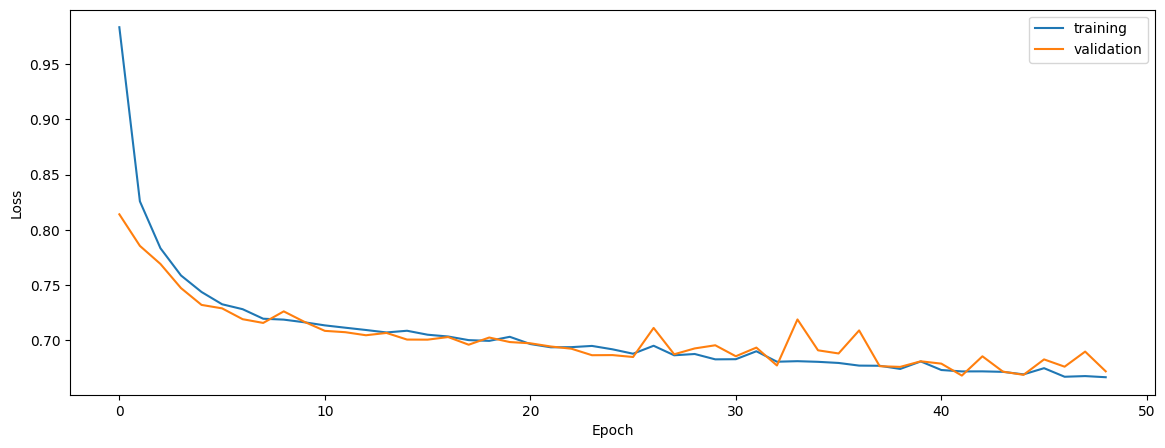

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.7069815583577256
0.704609403314553
0.7353187734392235


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6885703801751365
0.6905918651186957
0.7244955708360282


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.7026322150766595
0.7058277037026289
0.7339870669333214


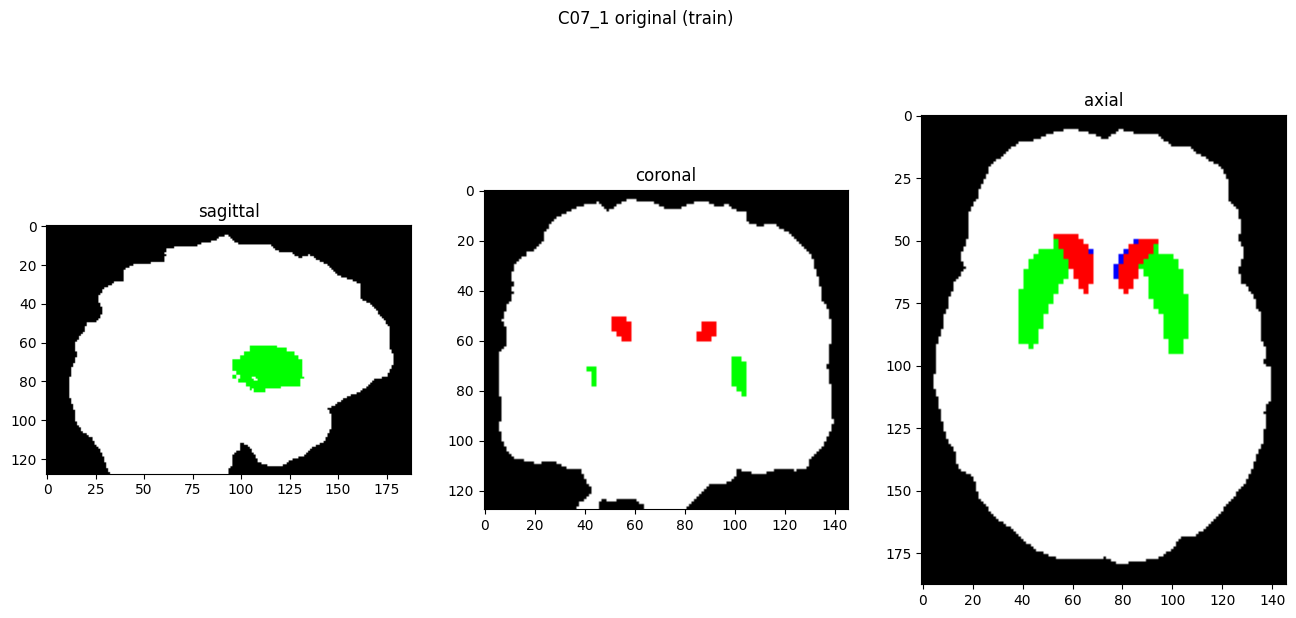

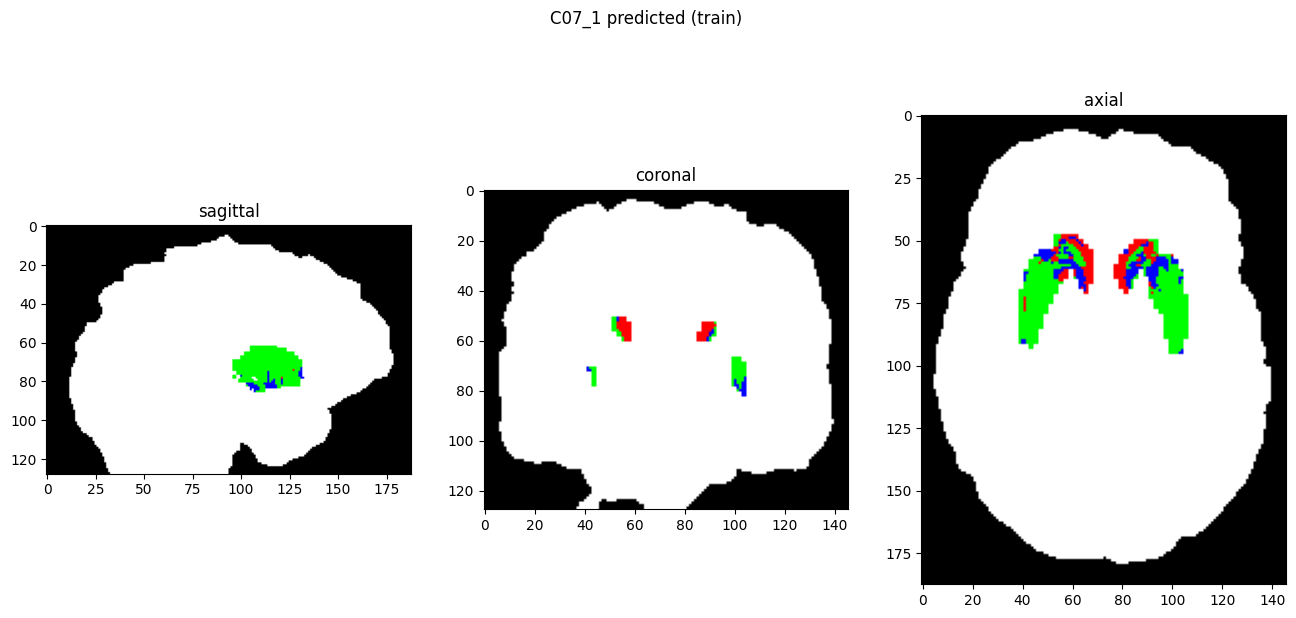

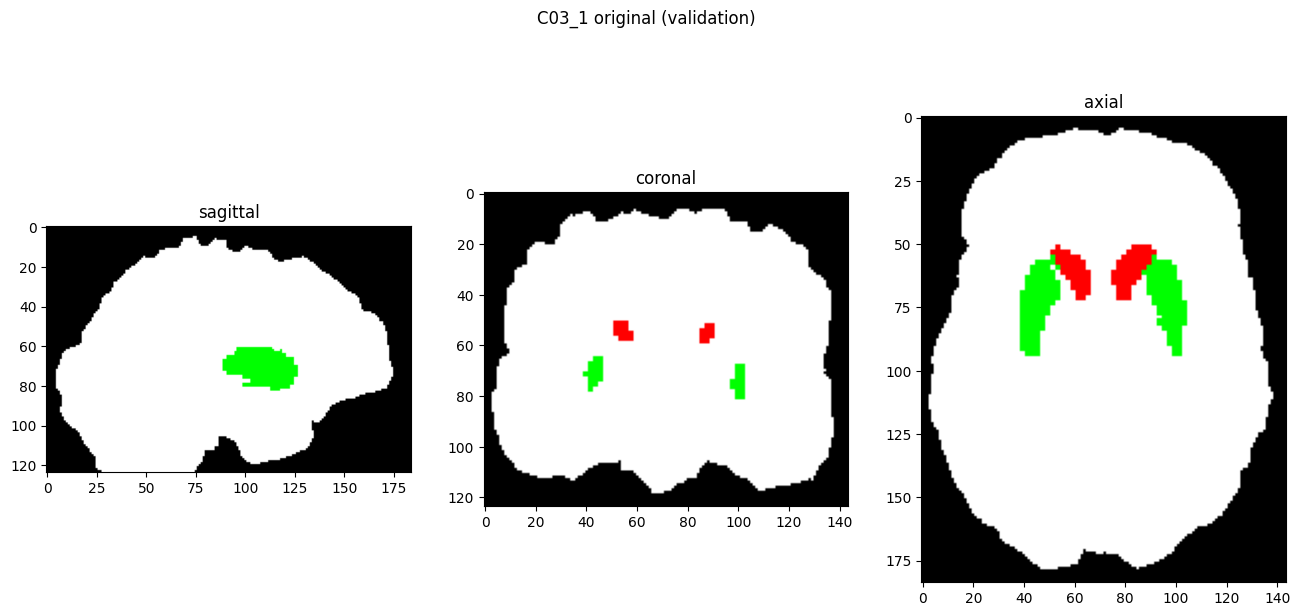

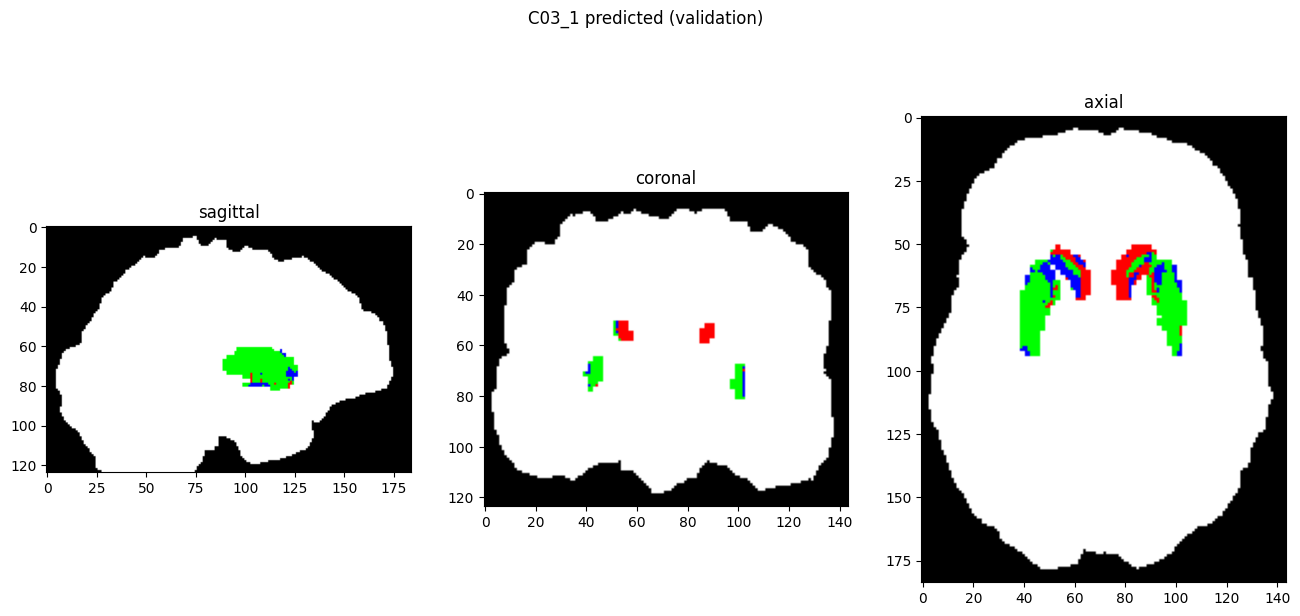

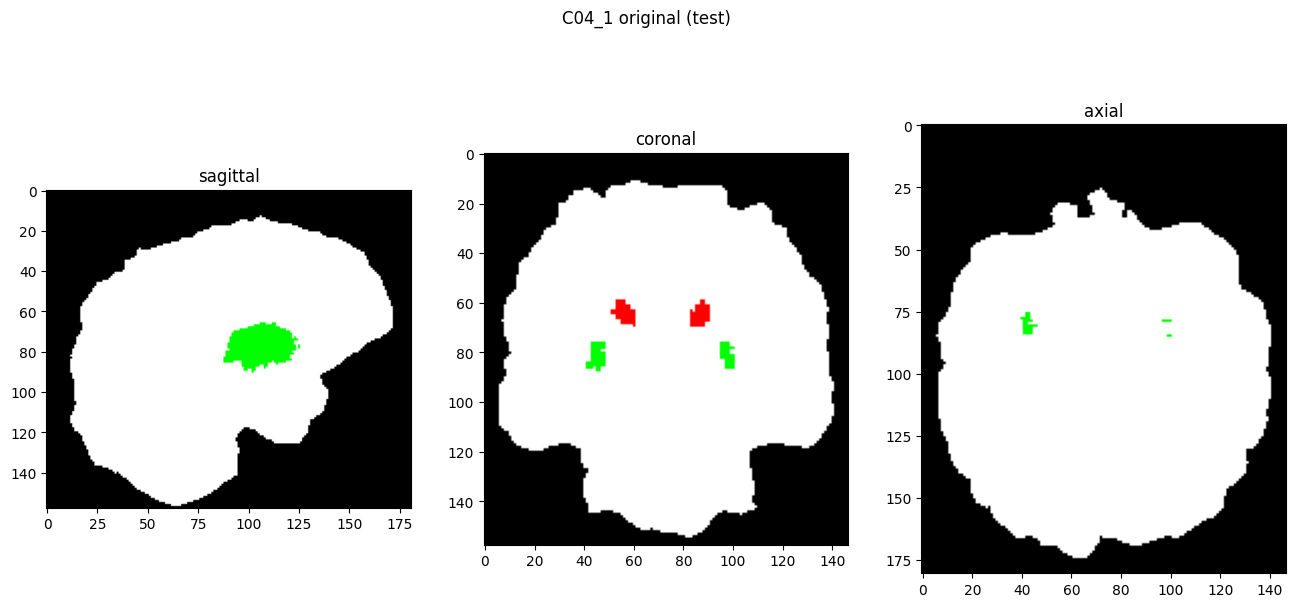

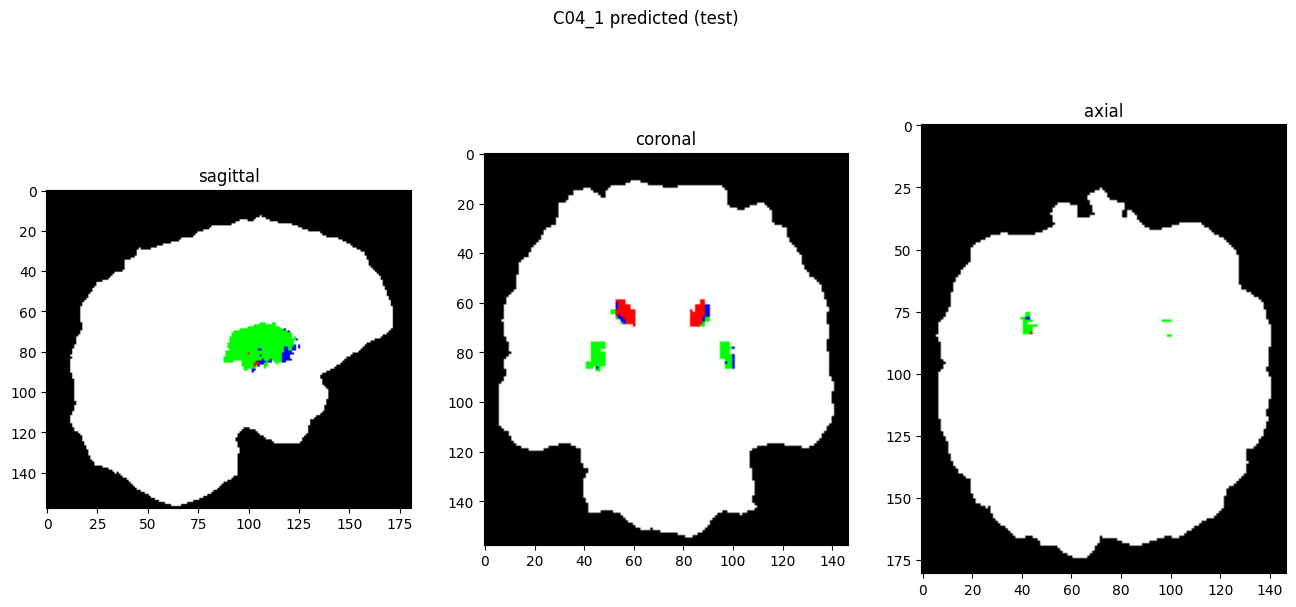

In [10]:
showResults(model, gen, threshold=0)